# Streambed seepage model of river at Oneto-Denier
We can apply TPROGs realizations to look at the expected variability in seepage and hyporheic zone residence times. This hyporheic zone residence time modeling could be completed on the local scale or regionally with a focus on the stream channel. Alternatively, the gages at McConnell, LWC and TWC could be used for regional seepage loss estimates, and again their is that satellite drying data.

## Model set up
Initial set up was a year long flow test with the primary boundary condition the SFR package and the GHB included to allow lateral groundwater outflow which is expected as the water entering the perched aquifers may transfer horizontally. Added evapotranspiration with EVT to allow dry season perched aquifer usage. Recharge was added then removed because it caused too much of a jump in levels. Added lake package to represent floodplain recharge in the 2D floodplain.

In [2]:
# standard python utilities
import os
import sys
from os.path import basename, dirname, join, exists
import glob
import time

import pandas as pd
import numpy as np
import numpy.ma as ma
from scipy.stats import gmean

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
# import pyproj # for converting proj4string
import shapely
# import shapefile
import geopandas as gpd
from osgeo import gdal
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [3]:
doc_dir = os.getcwd()
while os.path.basename(doc_dir) != 'Documents':
    doc_dir = os.path.dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = gwfm_dir + '/Oneto_Denier/'
dat_dir = proj_dir+'Stream_level_data/'

sfr_dir = gwfm_dir+'/SFR_data/'
uzf_dir = gwfm_dir+'/UZF_data/'

In [4]:
def add_path(fxn_dir):
    """ Insert fxn directory into first position on path so local functions supercede the global"""
    if fxn_dir not in sys.path:
        sys.path.insert(0, fxn_dir)
# flopy github path - edited
add_path(doc_dir+'/GitHub/flopy')
import flopy 

# other functions
py_dir = join(doc_dir,'GitHub/CosumnesRiverRecharge/python_utilities')
add_path(py_dir)

from mf_utility import get_layer_from_elev
from map_cln import gdf_bnds, plt_cln

In [5]:
tprogs_fxn_dir = doc_dir+'/GitHub/CosumnesRiverRecharge/tprogs_utilities'
add_path(tprogs_fxn_dir)
import tprogs_cleaning as tc

from importlib import reload
reload(tc)
tprogs_info = [80, -80, 320]


In [6]:
# reload(mf_utility)

# Time discretization


In [7]:
ss_bool = False

In [8]:
# Oneto-Denier data is about 2012-2019
# Transient -> might want to think about making SP1 steady
ss_strt = pd.to_datetime('2010-10-01')
strt_date = pd.to_datetime('2014-10-01')
# end_date = pd.to_datetime('2018-09-30') # end date for validation
end_date = pd.to_datetime('2020-9-30') # end time for analysis

dates = pd.date_range(strt_date, end_date)
# The number of periods is the number of dates 
nper = len(dates)
if ss_bool == True:
    nper = len(dates)+1

# Each period has a length of one because the timestep is one day, have the 1st stress period be out of the date range
# need to have the transient packages start on the second stress period
perlen = np.ones(nper).tolist()
# Steady or transient periods
steady = np.zeros(nper)
if ss_bool == True:
    steady[0] = 1 # first period is steady state, rest are transient
    perlen = [1/86400] + perlen[1:]
steady = steady.astype('bool').tolist()
# Reduce the number of timesteps to decrease run time
# when 1 day period have 6 stps, else 1 step
# trying out 1 step per period to reduce data output since not using sub daily output
nstp = np.where(np.asarray(perlen)==1, 1, 1)

In [9]:
# adjusters for boundary condition input
if ss_bool == False:
    time_tr0 = 0  
    nper_tr = nper 
else:
    time_tr0 = 1
    nper_tr = nper-1
print('NPER ', nper, 'NPER_TR ',nper_tr)

NPER  2192 NPER_TR  2192


# Grid discretization
- Since I'm no longer using small scale in-stream loggers there is no reason to use 100 m grid cells so should use 200 m and possibly expand the grid to further avoid boundary effects. Downside is set up is for 100 m for sfr XS and might be nice for finer resolution in near stream flow direction?
- It might also be worth considering 2 m thick layers instead of 4 m because Graham has been concerned with thin low permeability units. For finer upscaling we need to add filler layers to avoid issues with connectivity.
- the max difference in the dem is 10m so 20 tprogs layers, need to add 10 to unsat_thick

In [10]:
# load parent model grid
parent_grid = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
nrow_p = int(parent_grid.row.max())
ncol_p = int(parent_grid.column.max())

In [11]:
delr = 100
delc = 100
rotation=52.9

# model will only be in upper 0-70 ft of the domain, most likely only 0-30ft
unsat_thick = 50 # updated to enable inclusion of deeper ag pumping

upscale = 4 # from usual 0.5m
thick = 0.5*upscale
nlay_tprogs = int(unsat_thick/thick)
# adding one layer at bottom to deepen model to include pumping
nlay = nlay_tprogs + 1

# There is essentially no difference bewtween WGS84 and NAD83 for UTM Zone 10N
# proj4_str='EPSG:26910'
proj4_str='+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs '

# Choose location to subset grid

In [12]:
hob_dir = join(gwfm_dir,'HOB_data')

In [13]:
df = pd.read_csv(join(hob_dir,'CosumnesRiverPreserve_MW_screened_interval.csv'))
rm_sp = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.Longitude,df.Latitude), crs='epsg:4326')
rm_sp = rm_sp.to_crs('epsg:32610')
rm_sp = rm_sp.rename(columns={'Well ID':'Sensor'})

# prepare output for modelgrid join
rm_t = rm_sp[rm_sp['At Oneto-Denier']=='Yes'].copy()

rm_t[['top_screen','bot_screen']] = rm_t['Screened Interval (ft)'].str.split('-',n=2, expand=True).astype(float)
# calculate elevation from screened interval depth
rm_t['top_screen_m'] = rm_t['MPE (meters)'] - rm_t.top_screen*0.3048
rm_t['bot_screen_m'] = rm_t['MPE (meters)'] - rm_t.bot_screen*0.3048


The buffer distance could also be set by expanding the points of the monitoring so that the grid always aligns with the regional.

In [14]:

rm_t_buf = rm_t.copy()
rm_t_buf.geometry = rm_t_buf.geometry.buffer(3000)
# join monitoring extent with parent grid
rm_p_grid = gpd.sjoin(rm_t_buf, parent_grid)
# add 1000 m outward to limit bounary effects
# buf = int(1000/delr)
buf = 0
beg_row, beg_col = rm_p_grid.min(numeric_only=True)[['row','column']] - buf
end_row, end_col = rm_p_grid.max(numeric_only=True)[['row','column']] + buf


In [15]:

child_grid = parent_grid.loc[(parent_grid.row>=beg_row)&(parent_grid.row<end_row)]
child_grid = child_grid.loc[(child_grid.column>=beg_col)&(child_grid.column<end_col)]

child_grid = child_grid.rename({'node':'p_node','row':'p_row','column':'p_column'},axis=1)

In [16]:
child_grid['id'] = 0
m_domain = child_grid.dissolve('id')

<Axes: >

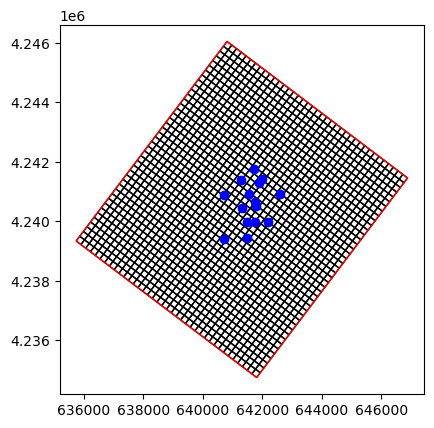

In [17]:
fig,ax=plt.subplots()
# child_extent.plot(ax=ax,color="None")
child_grid.plot(ax=ax, color="None")
m_domain.plot(color="none",edgecolor='red',ax=ax)
rm_t.plot(legend=False,ax=ax, color='blue')


In [18]:
# scale the nuber of rows/cols by change in dimensions
ncol = int(200/delr)*(child_grid.p_column.max() - child_grid.p_column.min()) + 1
nrow = int(200/delc)*(child_grid.p_row.max() - child_grid.p_row.min()) + 1

In [19]:
coords = list(m_domain.geometry.values[0].exterior.coords)
xul = np.min(coords)
yul = coords[np.where(coords==xul)[0][0]][1]

# Choose scenario (levee removal or not)
The historical scenario is levee removal to open the Oneto-Denier floodplain and the alternative is if the levee removal didn't occur. These scenarios will be compared for both stream seepage, baseflow and groundwater elevation.

In [204]:
# scenario = '' # baseline, levee removal occurred in 2014
# create identifier for scenario if levee removal didn't occur
scenario = 'no_reconnection'

In [205]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'

if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 
    
loadpth += '/GWFlowModel/Cosumnes/Stream_seepage/'
model_nam = 'oneto_denier_upscale'+str(upscale)+'x'
# model_nam = 'oneto_denier'
# model_nam = 'oneto_denier_homogeneous'

model_ws = loadpth+ model_nam +'_'+ str(strt_date.year)+'_'+str(end_date.year)
if scenario != '':
    model_ws += '_' + scenario

In [206]:
# m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'MODFLOW-NWT.exe', 
#                           version = 'mfnwt', model_ws=model_ws)
m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'mf-owhm', 
                          version = 'mfnwt', model_ws=model_ws)

#lenuni = 1 is in ft, lenuni = 2 is in meters
# itmuni is time unit 5 = years, 4=days, 3 =hours, 2=minutes, 1=seconds
dis = flopy.modflow.ModflowDis(nrow=nrow, ncol=ncol, 
                               nlay=nlay, delr=delr, delc=delc,
                               model=m, lenuni = 2, itmuni = 4,
                               xul = xul, yul = yul,rotation=rotation, proj4_str=proj4_str,
                              nper = nper, perlen=perlen, nstp=nstp, steady = steady,
                              start_datetime = strt_date)


In [22]:
os.makedirs(join(model_ws,'input_data'), exist_ok=True)

In [23]:
mg = m.modelgrid
ll = mg.get_coords(0, 0) #lower left
lr = mg.get_coords(0, nrow*delr) #lower right
ur = mg.get_coords(ncol*delc, nrow*delr) #upper right
ul = mg.get_coords(ncol*delc, 0) #upper left
print(ll, lr, ur, ul)

# Shapefile of model bounds
from shapely.geometry import Polygon
vertices = np.stack(np.asarray((ll,lr, ur, ul)))
vertices
geoms = Polygon(vertices)

(641728.5444779097, 4234815.203668547) (635746.6650117205, 4239339.263576636) (640753.2913100063, 4245959.210185885) (646735.1707761955, 4241435.150277796)


In [24]:
# write modelgrid to get updated row and col numbers specific to the child grid
grid_dir = join(gwfm_dir, 'DIS_data/streambed_seepage/grid')
grid_fn = join(grid_dir, 'inset_oneto_denier','rm_only_grid.shp')

# m.modelgrid.write_shapefile(grid_fn)
grid_p = gpd.read_file(grid_fn)
grid_p.crs = 'epsg:32610'

In [25]:
# get exterior polyline of model grid
grid_bnd = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_p.unary_union.exterior], crs=grid_p.crs)
# find cells that construct the model boundary
bnd_cells = gpd.sjoin(grid_p, grid_bnd)
bnd_cells = bnd_cells[['row','column']] - 1
bnd_cells['grid_id'] = np.arange(0,len(bnd_cells))
bnd_rows, bnd_cols = bnd_cells.row.values, bnd_cells.column.values

In [26]:
# find matching based on current grid
grid_match = gpd.sjoin(child_grid, grid_p, predicate = 'intersects', how = 'left')
# grid_match.to_file(join(proj_dir, 'GIS','grid_match.shp'))
# grid_match.row = grid_match.row.astype(int)
# grid_match.column = grid_match.column.astype(int)

Top of child grid needs to coincide with the top of the parent grid if vertical grid refinement is applied
It would be interesting to look at including the transfer of flow between the parent and child model as it is not currently implemented in MODFLOW. Need to create relation between parent and child grid row, column numbers

In [27]:

dem_data_p = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_mean.tsv')

dem_data = np.zeros((nrow,ncol))
dem_data[grid_match.row-1, grid_match.column-1] = dem_data_p[grid_match.p_row-1, grid_match.p_column-1]

# dem_data.max() - dem_data.min() # there is a max of a 20 layer difference which would be 2 layers after 8x upscale

<>:1: DeprecationWarning: invalid escape sequence '\D'
<>:1: DeprecationWarning: invalid escape sequence '\D'
C:\Users\andrewc\AppData\Local\Temp\ipykernel_15012\1314145472.py:1: DeprecationWarning: invalid escape sequence '\D'
  dem_data_p = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_mean.tsv')


In [152]:
# if i use finer upscaling like 4x or 2x then the offset could be more problematic
# need to create zero thickness layers when layering would be above land surface
tprogs_strt = tc.elev_to_tprogs_layers(dem_data, tprogs_info)
# model will need to extend from 0m at highest point in dem to -40 in lowest point in dem
tprogs_strt.min()- tprogs_strt.max()

-21

In [153]:
# create array of botm elevations for tprogs
tprogs_max_elev = 80-tprogs_strt.min()*0.5
tprogs_min_elev = tprogs_max_elev - thick*nlay_tprogs

tprogs_botm = np.zeros((nlay_tprogs, nrow,ncol))
tprogs_botm[0,:,:] = tprogs_max_elev - thick
for k in np.arange(1,nlay_tprogs):
    tprogs_botm[k,:] = tprogs_botm[k-1,:] - thick


MODFLOW doesn't like have layers of near zero thickness. I'm going to have to rely on setting the cells inactive above the DEM.  
I'm also adding a thick bottom layer to add deeper pumping (-150 m bottom to include ag wells at 300 ft)
The deepest wells are 180 m so the botm should be set to 200 m to include all ag wells.

In [154]:
# where the tprogs_botm is greater than the model top set as near zero thickness (1 nm, 1E-6 m)
botm = np.zeros(m.dis.botm.shape)
botm[:nlay_tprogs] = np.copy(tprogs_botm)
if nlay-nlay_tprogs==1:
    botm[-1] = -200

# botm[0,tprogs_botm[0]>dem_data]  = dem_data[tprogs_botm[0]>dem_data] - 1E-3
# # for k in np.arange(nlay-1, -1, -1):
# for k in np.arange(1,nlay):
#     # where the bottom elevation is above the top set the elevation as top minus a fraction
#     botm[k,botm[k]>dem_data] = botm[k-1,botm[k]>dem_data] - 1E-3
    


In [207]:
# model top is the same as the regional model
# m.dis.top = np.copy(dem_data)
# for version when using rectangular 3d grid
m.dis.top = np.full((nrow,ncol),int(dem_data.max()))

# set value in flopy
m.dis.botm = botm

In [208]:
# dis.write_file()

# LPF
After running all 100 realizations it is possible to subset and choose a realization with lower error if desired

In [157]:
mf_tprogs_dir = gwfm_dir+'/UPW_data/tprogs_final/'
tprogs_files = glob.glob(mf_tprogs_dir+'*')

gel_dir = gwfm_dir+'/UPW_data'
if 'ZonePropertiesInitial.csv' in os.listdir(model_ws):
    print('exists')
    params = pd.read_csv(model_ws+'/ZonePropertiesInitial.csv',index_col='Zone')
else:
    params = pd.read_csv(gel_dir+'/ZonePropertiesInitial.csv',index_col='Zone')
    params.to_csv(model_ws+'/ZonePropertiesInitial.csv')
    
# convert from m/s to m/d
params['K_m_d'] = params.K_m_s * 86400    

exists


In [158]:

t=11 # realization with NSE>0.5
tprogs_line = np.loadtxt(tprogs_files[t])
# filter elevation by regional model
# masked_tprogs= tc.tprogs_cut_elev(tprogs_line, dem_data_p, tprogs_info)
# if want to keep full hk, vka then don't crop elevation
masked_tprogs= tc.tprogs_cut_elev(tprogs_line, np.full((nrow_p,ncol_p),80), tprogs_info)
# subset masked data to local model
masked_tprogs_local = np.zeros((tprogs_info[2], nrow, ncol))
masked_tprogs_local[:, grid_match.row-1, grid_match.column-1] = masked_tprogs[:,grid_match.p_row-1, grid_match.p_column-1]
masked_tprogs_local = ma.masked_invalid(masked_tprogs_local)

# K, Sy, Ss= tc.int_to_param(masked_tprogs_local, params)
K, Sy, Ss, porosity = tc.int_to_param(masked_tprogs_local, params, porosity=True)

# save tprogs facies array as input data for use during calibration
# tprogs_dim = masked_tprogs.shape
# np.savetxt(model_ws+'/input_data/tprogs_facies_array.tsv', 
#            np.reshape(masked_tprogs, (tprogs_dim[0]*nrow,ncol)), delimiter='\t')
# masked_tprogs = np.reshape(np.loadtxt(model_ws+'/input_data/tprogs_facies_array.tsv', delimiter='\t'), (320,100,230))


In [159]:
hk = np.zeros(botm.shape)
vka = np.zeros(botm.shape)
sy = np.zeros(botm.shape)
ss = np.zeros(botm.shape)
por = np.zeros(botm.shape)
# for old method with sample directly below dem
# top = np.copy(m.dis.top.array)
# sample full block of tprogs, but set inactive parts above dem
top = np.full((nrow,ncol),dem_data.max())
# tprogs goes until bottom of tprogs
bot1 = np.copy(botm[nlay_tprogs-1,:,:])
# tprogs_info = ()
from scipy.stats import hmean, gmean

# I need to verify if a flattening layer is needed (e.g., variable thickness to maintain TPROGs connectivity)
# pull out the TPROGS data for the corresponding depths
K_c = tc.get_tprogs_for_elev(K, top, bot1,tprogs_info)
Ss_c = tc.get_tprogs_for_elev(Ss, top, bot1,tprogs_info)
Sy_c = tc.get_tprogs_for_elev(Sy, top, bot1,tprogs_info)
por_c = tc.get_tprogs_for_elev(porosity, top, bot1,tprogs_info)

# upscale as preset
for k in np.arange(0, nlay_tprogs):
    hk[k,:] = np.mean(K_c[upscale*k:upscale*(k+1)], axis=0)
    vka[k,:] = hmean(K_c[upscale*k:upscale*(k+1)], axis=0)
    if np.isnan(hmean(K_c[upscale*k:upscale*(k+1)], axis=0)).any():
        print(k)
    ss[k,:] = np.mean(Ss_c[upscale*k:upscale*(k+1)], axis=0)
    sy[k,:] = np.mean(Sy_c[upscale*k:upscale*(k+1)], axis=0)
    por[k,:] = np.mean(por_c[upscale*k:upscale*(k+1)], axis=0)



In [161]:
# check proportions of hydrofacies in TPROGs realization
tprogs_vals = np.arange(1,5)
tprogs_hist = np.histogram(masked_tprogs, np.append([0],tprogs_vals+0.1))[0]
tprogs_hist = tprogs_hist/np.sum(tprogs_hist)

tprogs_quants = 1 - np.append([0], np.cumsum(tprogs_hist)/np.sum(tprogs_hist))
vka_quants = pd.DataFrame(tprogs_quants[1:], columns=['quant'], index=tprogs_vals)
# dataframe summarizing dominant facies based on quantiles
vka_quants['vka_min'] = np.quantile(vka[:nlay_tprogs], tprogs_quants[1:])
vka_quants['vka_max'] = np.quantile(vka[:nlay_tprogs], tprogs_quants[:-1])
vka_quants['facies'] = params.loc[tprogs_vals].Lithology.values
# scale vertical conductivity with a vertical anisotropy factor based
# on quantiles in the upscaled tprogs data
for p in tprogs_vals:
    vka[(vka<vka_quants.loc[p,'vka_max'])&(vka>vka_quants.loc[p,'vka_min'])] /= params.vani[p]


In [162]:
# this may not be needed
# reduce sand/gravel vka for seepage in LAK/SFR assuming some fining
seep_vka = np.copy(vka)
coarse_cutoff = vka_quants.loc[2,'vka_min'] # sand minimum
seep_vka[seep_vka > coarse_cutoff] /= 10
print('coarse cutoff %.1f' %coarse_cutoff)

coarse cutoff 21.6


In [163]:
# after upscaling each layer horizontally the values are very similar (all same order of magnitude)
# upscale vertically first then laterally (or else small values are washed out)
if model_nam.__contains__('homogeneous'):
    hk[:] = np.nanmean(hk)
    vka[:] = hmean(vka, axis=(0,1,2)) #np.nanmean(hmean(vka))
    ss[:] = np.nanmean(ss)
    sy[:] = np.nanmean(sy)


In [164]:
if nlay - nlay_tprogs==1:
    # set values for second to bottom layer, Laguna formation
    hk[-1,:,:] = params.loc[5,'K_m_d']
    vka[-1,:,:] = params.loc[5,'K_m_d']/params.loc[5,'vani'] 
    sy[-1,:,:] = params.loc[5,'Sy']
    ss[-1,:,:] = params.loc[5,'Ss']
    por[-1,:,:] = params.loc[5,'porosity']


In [165]:
np.savetxt(model_ws+'/porosity_arr.tsv', np.reshape(por, (nlay*nrow,ncol)),delimiter='\t')

# layvka 0 means vka is vert K, non zero means its the anisotropy ratio between horiz and vert
layvka = 0

# LAYTYP MUST BE GREATER THAN ZERO WHEN IUZFOPT IS 2
# 0 is confined, >0 convertible, <0 convertible unless the THICKSTRT option is in effect
# try making first 20 m convertible/ unconfined, 
num_unconf = int(20/thick)
laytyp = np.append(np.ones(num_unconf), np.zeros(nlay-num_unconf))

# Laywet must be 0 if laytyp is confined laywet = [1,1,1,1,1]
laywet = np.zeros(len(laytyp))
laywet[laytyp==1] = 1
#ipakcb = 55 means cell-by-cell budget is saved because it is non zero (default is 53)
gel = flopy.modflow.ModflowUpw(model = m, hk =hk, layvka = layvka, vka = vka, 
                               sy=sy, ss=ss,
                               iphdry = 0, # must be 1 for modpath (use hdry), should be 0 for HOB (no dry)
                            laytyp=laytyp, laywet = 0, # laywet must be 0 for UPW
                               ipakcb=55) 

# gel = flopy.modflow.ModflowLpf(model = m, hk =hk, layvka = layvka, vka = vka,  
# #                                ss = storativity, storagecoefficient=True, #storativity
#                                ss=ss, sy=sy,
#                                laytyp=laytyp, laywet = laywet, ipakcb=55)

In [166]:
# gel.write_file()

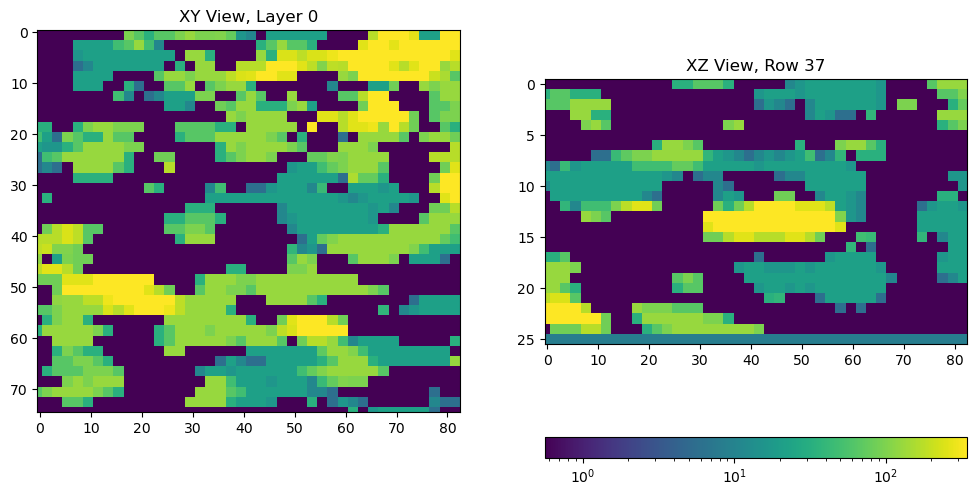

In [167]:
fig,ax = plt.subplots(1,2, figsize=(12,8))
ax[0].set_title('XY View, Layer 0')
ax[0].imshow(gel.hk.array[0,:,:], norm = mpl.colors.LogNorm())
ax[1].set_title('XZ View, Row '+str(int(nrow/2)))
im = ax[1].imshow(gel.hk.array[:,int(nrow/2),:], norm = mpl.colors.LogNorm())
ax[1].set_aspect(2)
plt.colorbar(im, orientation='horizontal', location='bottom')

# SFR/LAKE data

In [168]:
lak_shp = join(gwfm_dir,'LAK_data/floodplain_delineation')
# ifp = gpd.read_file(join(lak_shp,'inner_floodplain_domain/inner_floodplain_domain.shp' )).to_crs('epsg:32610')
# lfp = gpd.read_file(join(lak_shp,'lower_floodplain_approximate_area/lower_floodplain_approximate_area.shp' )).to_crs('epsg:32610')
lak_extent = gpd.read_file(join(lak_shp,'LCRFR_ModelDom_2017/LCRFR_2DArea_2015.shp' )).to_crs('epsg:32610')

fp_logger = pd.read_csv(join(gwfm_dir,'LAK_data','floodplain_logger_metadata.csv'))
fp_logger = gpd.GeoDataFrame(fp_logger, geometry = gpd.points_from_xy(fp_logger.Easting, fp_logger.Northing), crs='epsg:32610')
# find grid cell it is within
fp_grid = gpd.sjoin(fp_logger, grid_p, how='left',predicate='within')

## Load ET/precip data
Load data for the years simulated then crop to the days simulated. 

In [169]:
import h5py
def dwr_etc(strt_date, end_date):
    nper_tr = (end_date-strt_date).days+1
    natETc = np.zeros((nper_tr,nrow_p,ncol_p))
    agETc = np.zeros((nper_tr,nrow_p,ncol_p))

    per_n = 0 
    for y in np.arange(strt_date.year, end_date.year+1):
        # set start and end date for range for the year to be iterated over
        yr_strt = pd.to_datetime(str(y)+'-01-01')
        yr_end = pd.to_datetime(str(y)+'-12-31')
        # get the length of the date range needed for that year
        yearlen = len(pd.date_range(yr_strt, yr_end))
        if yr_strt < strt_date:
            yr_strt = strt_date
        if yr_end > end_date:
            yr_end = end_date
        yr_len = len(pd.date_range(yr_strt, yr_end))
        # load hdf5 files
        f_irr = h5py.File(join(uzf_dir, "dwr_ETc/irrigated_"+str(y)+".hdf5"), "r")
        agETc[per_n:per_n+yr_len,:,:] = f_irr['array'][str(y)][:][yr_strt.dayofyear-1:yr_end.dayofyear,:,:]
        f_irr.close()
        f_nat = h5py.File(join(uzf_dir, "dwr_ETc/native_"+str(y)+".hdf5"), "r")
        natETc[per_n:per_n+yr_len,:,:] = f_nat['array'][str(y)][:][yr_strt.dayofyear-1:yr_end.dayofyear,:,:]
        f_nat.close()
        per_n += yr_len
    # make sure the return value is separate from the loop
    return(agETc, natETc)

In [170]:
agETc, natETc = dwr_etc(strt_date, end_date)
# net ETc should be ETc from ag and native plants joined
ETc = agETc + natETc

In [ ]:
ss_agETc, ss_natETc = dwr_etc(ss_strt, strt_date)
ss_ETc = ss_agETc+ss_natETc

In [ ]:
ss_ndays = (strt_date-ss_strt).days+1


In [ ]:
# subset data to local model
et_local = np.zeros((nper_tr, nrow, ncol))
et_local[:, grid_match.row-1, grid_match.column-1] = ETc[:,grid_match.p_row-1, grid_match.p_column-1]
ss_et_local = np.zeros((ss_ndays, nrow, ncol))
ss_et_local[:, grid_match.row-1, grid_match.column-1] = ss_ETc[:,grid_match.p_row-1, grid_match.p_column-1]


# subset data to local model
ag_local = np.zeros((nper_tr, nrow, ncol))
ag_local[:, grid_match.row-1, grid_match.column-1] = agETc[:,grid_match.p_row-1, grid_match.p_column-1]
ss_ag_local = np.zeros((ss_ndays, nrow, ncol))
ss_ag_local[:, grid_match.row-1, grid_match.column-1] = ss_agETc[:,grid_match.p_row-1, grid_match.p_column-1]



In [ ]:
## Potential ETo spatial interpolation from CIMIS
fn = glob.glob(join(uzf_dir,'Cosumnes_dailyET_precip*.csv'))
daily_data = pd.DataFrame()
for file in fn:
    new_data = pd.read_csv(file, index_col = ['Date'], parse_dates = True)
    daily_data = pd.concat((daily_data, new_data))
# units of mm
data_in = daily_data[daily_data['Stn Name']=='Fair Oaks']
# clean up data so columns are by location, units of Precip are in mm
rain_in = data_in.pivot_table(index = 'Date', columns = 'Stn Name', values = 'Precip (mm)')
rain_m = rain_in/1000

# create array for every period of rainfall
rain_df = rain_m[strt_date:end_date].resample('D').interpolate('zero')['Fair Oaks']
rain = np.repeat(np.repeat(np.reshape(rain_df.values, (rain_df.shape[0],1,1)), nrow, axis=1),ncol, axis=2)

rain_df = rain_m[ss_strt:strt_date].resample('D').interpolate('zero')['Fair Oaks']
ss_rain = np.repeat(np.repeat(np.reshape(rain_df.values, (rain_df.shape[0],1,1)), nrow, axis=1),ncol, axis=2)


In [ ]:
def load_perc(strt_date, end_date):
    nper_tr = (end_date-strt_date).days+1
    # years and array index 
    years = pd.date_range(strt_date,end_date,freq='AS-Oct')
    yr_ind = (years-strt_date).days
    perc = np.zeros((nper_tr, nrow_p,ncol_p))
    # need separte hdf5 for each year because total is 300MB
    for n in np.arange(0,len(yr_ind)-1):
    #     arr = pc[yr_ind[n]:yr_ind[n+1]]
        fn = join(uzf_dir, 'basic_soil_budget',"percolation_WY"+str(years[n].year+1)+".hdf5")
        f = h5py.File(fn, "r")
        arr = f['array']['WY'][:]
        perc[yr_ind[n]:yr_ind[n+1]] = arr
    #     arr_to_h5(arr, fn)
        f.close()
    return(perc)

finf = load_perc(strt_date, end_date)
ss_finf = load_perc(ss_strt, strt_date)


In [ ]:
# subset data to local model
finf_local = np.zeros((nper_tr, nrow, ncol))
finf_local[:, grid_match.row-1, grid_match.column-1] = finf[:,grid_match.p_row-1, grid_match.p_column-1]
ss_finf_local = np.zeros((ss_ndays, nrow, ncol))
ss_finf_local[:, grid_match.row-1, grid_match.column-1] = ss_finf[:,grid_match.p_row-1, grid_match.p_column-1]

# percolation can't exceed vertical conductivity (secondary runoff)
finf_local = np.where(finf_local >vka[0,:,:], vka[0,:,:], finf_local)
ss_finf_local = np.where(ss_finf_local >vka[0,:,:], vka[0,:,:], ss_finf_local)

## Prepare Lake bathymetry

In [ ]:
fn = join(lak_shp,"floodplain_crop.tif")
if not exists(fn):
    # create clipped raster of just lake area
    dem_dir = join(gwfm_dir,'DEM_data')
    raster_name = dem_dir+'/mwt_peri_2_3.tif/mwt_peri_2_3_clipped.tif'
    import rasterio.mask
    with rasterio.open(raster_name) as src:
        out_image, out_transform = rasterio.mask.mask(src, lak_extent.geometry.values, crop=True)
        out_meta = src.meta
    # write output
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(join(lak_shp,"floodplain_crop.tif"), "w", **out_meta) as dest:
        dest.write(out_image)

# prepare bathymetry file
lakeRst = rasterio.open(join(lak_shp,"floodplain_crop.tif"))
lakeBottom = lakeRst.read(1)
noDataValue = np.copy(lakeBottom[0,0])
#replace value for np.nan
lakeBottom[lakeBottom==noDataValue]= np.nan

# get raster minimum and maximum 
minElev = np.nanmin(lakeBottom)
maxElev = np.nanmax(lakeBottom)
print('Min bottom elevation %.2f m., max bottom elevation %.2f m.'%(minElev,maxElev))

# steps for calculation
nSteps = 151
# lake bottom elevation intervals
elevSteps = np.round(np.linspace(minElev,maxElev,nSteps),2)

# definition of volume function
def calculateVol_A(elevStep,elevDem,lakeRst, conv=1):
    tempDem = elevStep - elevDem[elevDem<elevStep]
    tempArea = len(tempDem)*lakeRst.res[0]*conv*lakeRst.res[1]*conv
    tempVol = tempDem.sum()*lakeRst.res[0]*conv*lakeRst.res[1]*conv
    return(tempVol, tempArea)
# calculate volumes, areas for each elevation
volArray = [0]
saArray = [0]
for elev in elevSteps[1:]:
    tempVol,tempArea = calculateVol_A(elev,lakeBottom,lakeRst)
    volArray.append(tempVol)
    saArray.append(tempArea)

# print("Lake bottom elevations %s"%elevSteps)
volArrayMCM = round(volArray[-1]/1000000,2) 
print("Lake volume in million of cubic meters %s"%volArrayMCM)

In [ ]:
# lak_buf = lak_extent[['OID_','geometry']].copy()
# lak_buf.geometry = lak_buf.buffer(10)
lak_grid = gpd.overlay(grid_p, lak_extent[['OID_','geometry']], how='intersection')
# check if more than 50% of cell is covered by the lake, avoid conflicts with sfr
lak_grid = lak_grid.loc[lak_grid.geometry.area > (delr*delc*0.5)]


# SFR

## XS pre-processing

In [ ]:
# cross sections sampled using NHD lines at regular 100 m intervals (not aligned with any grid)
xs_all = pd.read_csv(dat_dir+'XS_point_elevations.csv',index_col=0)
xs_all = gpd.GeoDataFrame(xs_all,geometry = gpd.points_from_xy(xs_all.Easting,xs_all.Northing), crs='epsg:32610')

# find XS that are in the modeled domain by thalweg point
thalweg = xs_all[xs_all.dist_from_right_m==100]
thalweg = gpd.overlay(thalweg, grid_p)
# thalweg = gpd.sjoin_nearest(grid_p, thalweg, how='inner')
# thalweg = thalweg.cx[xmin:xmax, ymin:ymax]
# with XS every 100m I need to choose whether the first or second is used in a cell
# thalweg = thalweg.dissolve(by='node', aggfunc='first')

# pivot based on XS number and save only elevation in z_m
xs_all_df = pd.read_csv(dat_dir+'Elevation_by_XS_number_meters.csv',index_col=0)
xs_all_df = xs_all_df.dropna(axis=0,how='any')

# filter XS by those that are within the domain bounds
xs_all = xs_all[xs_all.xs_num.isin(thalweg.xs_num.values)]
xs_all_df = xs_all_df.loc[:, thalweg.xs_num.astype(str)]

# renumber XS
thalweg.xs_num = np.arange(0,thalweg.shape[0])
xs_all.xs_num = np.repeat(thalweg.xs_num.values,xs_all.dist_from_right_m.max()+1)
xs_all_df.columns = thalweg.xs_num

In [ ]:
from shapely.geometry import LineString
i = 0
# Number of cross sections
numxs = int(len(xs_all_df.columns))
# i is the cross-section number
lp = pd.DataFrame(np.linspace(1,int(numxs),int(numxs)))
lp['geometry'] = LineString([(0,0),(0,1)])

for i in np.arange(0,numxs): #numxs
    # Number of points in each cross section
    numl = np.sum(pd.notna(xs_all_df.iloc[:,i]))
    # Create empty array to fill with coordinates
    lines = np.zeros((numl,2))
    # j is the number of points in each individual cross-section
    lm = LineString(list(zip(xs_all_df.index.values, xs_all_df.iloc[:,i].values)))
    tol = 0.6
    deltol = 0.1
    count = 0
    lms = LineString(lm).simplify(tolerance = tol)
    while len(list(lms.coords))>8:
        if len(list(lms.coords)) <5:
            deltol = 0.001
        temp = lms
        lms = LineString(lm).simplify(tolerance = tol)
        tol += deltol
#         if count drops below 8 then reduce deltol
#         if len(list(lms.coords)) <6:
#             lms = temp
#             tol -= deltol
#             deltol *= 0.5     
        count += 1

    print(i,':',len(list(lms.coords)),end = ' - ') #count, 
    lp.geometry.iloc[int(i)] = LineString(lms)
    
# some segments will never be able to match the ideal number of points despite very fine loops

In [ ]:
# create summary of XS for creating SFR inputs
xs_wide = xs_all.pivot_table(index='dist_from_right_m',values='z_m',columns='xs_num')
thalweg_pts = xs_wide.idxmin().values.astype(int)
xs_mins = xs_all.set_index(['dist_from_right_m','xs_num']).loc[list(zip(thalweg_pts, xs_wide.columns))]
XSg_in = xs_mins.reset_index('dist_from_right_m')

# join segment data to grid
XSg_in = gpd.sjoin(XSg_in, grid_p, predicate='within', how='inner')
# if multiple points in one cell take first, not a big deal since there are points every 100 m
XSg_in = XSg_in.reset_index().groupby(['row','column'], as_index=False).first()
XSg_in = XSg_in.sort_values('xs_num')
# create segment numbers, starting at 1 to allow for first segment defined by michigan bar criteria
XSg_in['iseg'] = np.arange(1, XSg_in.shape[0]+1) # add the segment that corresponds to each cross section
XSg_in.crs = xs_all.crs


In [ ]:
# filter cross sections to those that matched in the grid
xs_all = xs_all[xs_all.xs_num.isin(XSg_in.xs_num)]
xs_all_df = xs_all_df.loc[:, XSg_in.xs_num]

In [ ]:
XS8pt = pd.DataFrame(np.zeros((numxs*8, 3)), columns=['xs_num','dist_from_right_m','z_m'])
XS8pt.xs_num = np.repeat(np.arange(0,numxs), 8)

# lpg = gpd.GeoDataFrame(lp[:])
xscoords = np.zeros((8, numxs))
filler = np.zeros(2)
filler[:] = np.nan
for i in np.arange(0, numxs):
    coordtemp = np.array(list(lp.geometry.iloc[i].coords))
    coordtemp = coordtemp[~np.isnan(coordtemp[:,0])]
    # if missing points add to make 8
    while len(coordtemp) < 8:
        endfill = np.copy(coordtemp[-1,:]) # take last and add new point
        endfill[0] += 1 # offset with different x
        coordtemp = np.vstack((coordtemp, endfill))
    # reset distance from right to start at 0
    coordtemp[:,0] -= coordtemp[0,0]
    XS8pt.loc[XS8pt.xs_num==i,['dist_from_right_m','z_m']] = coordtemp   

# filter for XS in final segments
XS8pt = XS8pt.loc[XS8pt.xs_num.isin(XSg_in.xs_num)]
XS8pt.to_csv(proj_dir + '8pointXS_'+model_nam+'.csv', index = False)
XS8pt = XS8pt.set_index('xs_num')


In [ ]:
# even plotting all XS they show the same triangular shape
fig,ax = plt.subplots()
for n in XS8pt.index.unique()[::10]:
    XS8pt.loc[n].plot(x='dist_from_right_m',y='z_m', ax=ax,legend=False)

In [ ]:
XSg_z = XSg_in.copy().set_index('iseg')

# find minimum value in XS related to thalweg
XSg_z['z_m_min'] = xs_all.dissolve('xs_num','min').z_m
#roling mean of 6 window centered removes any negative slope
XSg_z['z_m_min_cln'] = XSg_z.z_m_min.rolling(6,center=False).mean()

# calculate slope and fill NAs, fill slope with nearby
z_cln_diff = XSg_z.z_m_min_cln.diff().bfill()
XSg_z['slope'] = z_cln_diff.abs()/delr
# correct slope less than 1E-4
XSg_z.loc[XSg_z.slope<1E-4,'slope'] = 1E-4

# fix str bot so all is downward sloping
for i in XSg_z.index[-2::-1]:
# fill NAs due to rolling mean, with backward filling
    if np.isnan(XSg_z.loc[i,'z_m_min_cln']):
        XSg_z.loc[i,'z_m_min_cln'] = XSg_z.loc[i+1,'z_m_min_cln'] + XSg_z.loc[i,'slope']*delr

for i in XSg_z.index[:-1]:
    if XSg_z.loc[i+1,'z_m_min_cln'] >= XSg_z.loc[i,'z_m_min_cln']:
        XSg_z.loc[i+1,'z_m_min_cln'] = XSg_z.loc[i,'z_m_min_cln'] - XSg_z.loc[i,'slope']*delr


# XSg_z.slope.plot(secondary_y = True)

In [ ]:
if scenario != 'no_reconnection':
    # identify XS to be copied for diversion reaches
    fp_grid_xs = fp_grid[['Logger Location','geometry']].copy()
    fp_grid_xs = fp_grid_xs.sjoin_nearest(XSg_z.reset_index().drop(columns=['index_right']), how='inner')
    # od_breach is the sensor location where the breach was made in the levees for flow to leave the river
    od_breach = fp_grid_xs[fp_grid_xs['Logger Location']=='OD_Excavation'].copy()
    od_breach['xs_num'] -= 0.2 # adjust xs_num to set sorting order
    od_swale = fp_grid_xs[fp_grid_xs['Logger Location']=='SwaleBreach_1'].copy()
    od_swale['xs_num'] -= 0.2 # adjust xs_num to set sorting order
    # need to adjust elevation so transfer segment from floodplain diversion to stream is positive slope
    od_return = od_breach.copy()
    od_return['xs_num'] += 0.1 # adjust xs_num to set sorting order
    od_return.z_m_min_cln += od_return.slope*delr
    # add reaches for diversion
    XSg = pd.concat((XSg_z.reset_index(), od_breach, od_return, od_swale)) #, od_swale
else:
    XSg = XSg_z.reset_index().copy()

MODFLOW SFR does not sum diversions to tributary inflow. To sum a diversion to a tributary an extra segment must be added to convert the diversion into a tributary (OUTSEG).

In [ ]:

# redefine xs_num/iseg
XSg  = XSg.sort_values('xs_num')
XSg['iseg'] = np.arange(1,XSg.shape[0]+1)
XSg = XSg.set_index('iseg')

In [ ]:
# fill upstream with parameters from sensors
# pcols= ['strhc1', 'strthick', 'thts','thti','eps','uhc','thtr', 'roughch','roughbk']
# XSg[pcols] = XSg[pcols].bfill()

XSg.to_csv(join(model_ws,'04_XSg_filled.csv'))

In [ ]:
# plot, large spike in top elevation causes discontinuity
sfr_rows = (XSg.row.values-1).astype(int)
sfr_cols = (XSg.column.values-1).astype(int)
# Determine which layer the streamcell is in
# since the if statement only checks whether the first layer is greater than the streambed elevation, 
# owhm default raises layer to topmost active which is 1
strthick = 1
strtop = XSg.z_m_min_cln.values 
strbot = strtop - strthick


### Reach layering
as long as I base the sfr layer on str bottom there shouldn't be an issue in owhm if NO_REACH_LAYER_CHANGE is
 specified becasue it likes to set the layer to the uppermost active layer

In [ ]:
sfrt_lay = get_layer_from_elev(strtop, botm[:, sfr_rows, sfr_cols], m.dis.nlay)
sfr_lay = get_layer_from_elev(strbot, botm[:, sfr_rows, sfr_cols], m.dis.nlay)


In [ ]:
# double check no layer bottom is below
((strbot >botm[sfr_lay, sfr_rows, sfr_cols])==False).sum()
# flopy seems to think the layer bottom for layer 3 is 0.727

In [ ]:
(XSg.z_m_min_cln).plot(label='Str Top')
XSg.z_m_min.plot(label='min')
(XSg.z_m_min_cln-strthick).plot(label='Str Bot')

plt.plot(m.dis.top.array[ sfr_rows, sfr_cols], label='Model Top', ls='--',color='green')
# plt.plot(m.dis.botm.array[0, sfr_rows, sfr_cols], label='Lay 1 Bottom', ls='--',color='brown')
plt.plot(botm[sfrt_lay, sfr_rows, sfr_cols], label='SFRT Lay Bot', ls='--',color='black')
plt.plot(botm[sfr_lay, sfr_rows, sfr_cols], label='SFRB Lay Bot', ls='-.',color='grey')

plt.legend()

# it seems that the sfr layer is forced based on the str top but that the str botm can't be below the modflow cell bottom
# this means the top and bottom must be in the same cell

In [ ]:
if scenario !='no_reconnection':
    fig,ax=plt.subplots()
    # gdf_bnds(breach_grid,ax=ax, buf=200)
    # XSg.plot(ax=ax) # takes a while to plot
    od_breach.plot(ax=ax)
    od_swale.plot(ax=ax)
    # grid_p.plot(ax=ax,color='none')

    # fp_logger[fp_logger['Logger Type']=='Breach'].plot('Logger Location',ax=ax, legend=True, legend_kwds={'loc':(1,0.3)})
    lak_extent.plot(ax=ax, color='none')
    ctx.add_basemap(ax=ax, source = ctx.providers.Esri.WorldImagery, attribution=False, attribution_size=6,
                    crs = 'epsg:26910', alpha=0.8)

## SFR input

In [ ]:
# There is one reach for each cell that a river crosses
NSTRM = -len(XSg)
# There should a be a stream segment if there are major changes
# in variables in Item 4 or Item 6
# 1st segment is for the usgs Michigan Bar rating curve, one for each XS, plus 2 for the floodplain diversion
NSS = len(XSg) 
# NSS = 2
# nparseg (int) number of stream-segment definition with all parameters, must be zero when nstrm is negative
NPARSEG = 0
CONST = 86400 # mannings constant for SI units, 1.0 for seconds, 86400 for days, 60 for minutes
# real value equal to the tolerance of stream depth used in
# computing leakage between each stream reach and active model cell
DLEAK = 0.0001 # unit in lengths, 0.0001 is sufficient for units of meters
IPAKCB = 55
# writes out stream depth, width, conductance, gradient when cell by cell
# budget is specified and istcb2 is the unit folder
ISTCB2 = 54
# isfropt = 1 is no unsat flow
# specifies whether unsat flow beneath stream or not, isfropt 2 has properties read for each reach, isfropt 3 also has UHC
# read for each reach, isfropt 4 has properties read for each segment (no UHC), 5 reads for each segment with UHC
ISFROPT = 1
# nstrail (int), number of trailing weave increments used to represent a trailing wave, used to represent a decrease 
# in the surface infiltration rate. Can be increased to improve mass balance, values between 10-20 work well with error 
# beneath streams ranging between 0.001 and 0.01 percent, default is 10 (only when isfropt >1)
NSTRAIL = 20
# isuzn (int) tells max number of vertical cells used to define the unsaturated zone beneath a stream reach (default is 1)
ISUZN = 1
#nsfrsets (int) is max number of different sets of trailing waves (used to allocate arrays), a value of 30 is sufficient for problems
# where stream depth varies often, value doesn't effect run time (default is 30)
NSFRSETS = 30
# IRTFLG (int) indicates whether transient streamflow routing is active, must be specified if NSTRM <0. If IRTFLG >0 then
# flow will be routed with the kinematic-wave equations, otherwise it should be 0 (only for MF2005), default is 1
IRTFLG = 1
# numtim (int) is number of sub time steps used to route streamflow. Streamflow time step = MF Time step / NUMTIM. 
# Default is 2, only when IRTFLG >0
NUMTIM = 1
# weight (float) is a weighting factor used to calculate change in channel storage 0.5 - 1 (default of 0.75) 
WEIGHT = 0.75
# flwtol (float), flow tolerance, a value of 0.00003 m3/s has been used successfully (default of 0.0001)
# 0.00003 m3/s = 2.592 m3/day = 0.001 cfs
# a flow tolerance of 1 cfs is equal to 2446.57 m3/day
# if my units are in m3/day then flwtol should be in m3/day
FLWTOL = 0.00003*CONST

sfr = flopy.modflow.ModflowSfr2(model = m, nstrm = NSTRM, nss = NSS, nparseg = NPARSEG, 
                           const = CONST, dleak = DLEAK, ipakcb = IPAKCB, istcb2 = ISTCB2, 
                          isfropt = ISFROPT, nstrail = NSTRAIL, isuzn = ISUZN, irtflg = IRTFLG, 
                          numtim = NUMTIM, weight = WEIGHT, flwtol = FLWTOL,
                                reachinput=True, transroute=True, tabfiles=True,
#                                 options = ['NO_REACH_LAYER_CHANGE'],
                                tabfiles_dict={1: {'numval': nper, 'inuit': 56}}
                               )

In [ ]:
# only works on GitHub version with edits
# Add option block at the top of the sfr input file for tabfiles
options_line = ' reachinput transroute tabfiles 1 ' + str(nper) + ' no_reach_layer_change'
tab_option = flopy.utils.OptionBlock(options_line = options_line, package = sfr, block = True)
sfr.options = tab_option
# sfr.options

In [ ]:
# KRCH, IRCH, JRCH, ISEG, IREACH, RCHLEN, STRTOP, SLOPE, STRTHICK, STRHC1, THTS, THTI, EPS, UHC

columns = ['KRCH', 'IRCH', 'JRCH', 'ISEG', 'IREACH', 'RCHLEN', 'STRTOP', 
               'SLOPE', 'STRTHICK', 'STRHC1', 'THTS', 'THTI', 'EPS', 'UHC']

sfr.reach_data.node = XSg.node
sfr.reach_data.k = sfr_lay.astype(int)
sfr.reach_data.i = sfr_rows
sfr.reach_data.j = sfr_cols
sfr.reach_data.iseg = XSg.index
sfr.reach_data.ireach = 1 
sfr.reach_data.rchlen = 100 #xs_sfr.length_m.values
sfr.reach_data.strtop = XSg.z_m_min_cln.values
sfr.reach_data.slope = XSg.slope.values
 # a guess of 2 meters thick streambed was appropriate
sfr.reach_data.strthick = strthick
sfr.reach_data.strhc1 = seep_vka[sfr.reach_data.k, sfr.reach_data.i, sfr.reach_data.j]

# UZF parameters
# sfr.reach_data.thts = soiln_array[sfr.reach_data.i, sfr.reach_data.j]/100
# sfr.reach_data.thti = sfr.reach_data.thts
# sfr.reach_data.eps = soileps_array[sfr.reach_data.i, sfr.reach_data.j]
# sfr.reach_data.uhc = vka[0,sfr.reach_data.i, sfr.reach_data.j]


In [ ]:
plt.imshow(vka[:, sfr.reach_data.i, sfr.reach_data.j])

In [ ]:
plt.figure(figsize=(5,2))
plt.plot(sfr.reach_data.strhc1)
plt.xlabel('ISEG')
plt.ylabel('VKA (m/s)')
plt.yscale('log')

In [ ]:
mb4rl = pd.read_csv(sfr_dir+'michigan_bar_icalc4_data.csv', skiprows = 0, sep = ',')


In [ ]:
sfr_seg = sfr.segment_data[0].copy()

In [ ]:
# alternate version of segment data loading using if statements when filtering data rather than in a loop
sfr_seg.nseg = np.arange(1,NSS+1)

sfr_seg.icalc = 2 # Mannings and 8 point channel XS is 2 with plain MF, 5 with SAFE
# sfr_seg.icalc[0] = 4 # use stage, discharge width method for Michigan Bar (nseg=1)
sfr_seg.nstrpts[sfr_seg.icalc==4] = len(mb4rl) # specify number of points used for flow calcs
sfr_seg.outseg = sfr_seg.nseg+1 # the outsegment will typically be the next segment in the sequence
sfr_seg.iupseg = 0 # iupseg is zero for no diversion

# set a flow into segment 1 for the steady state model run
sfr_seg.flow[0] = 2.834*86400. # m3/day, originally 15 m3/s
# set the values for ET, runoff and PPT to 0 as the inflow will be small relative to the flow in the river
sfr_seg.runoff = 0.0
sfr_seg.etsw = 0.0
sfr_seg.pptsw = 0.0

# Manning's n data comes from Barnes 1967 UGSS Paper 1849 and USGS 1989 report on selecting manning's n
# RoughCH is only specified for icalc = 1 or 2
sfr_seg.roughch[(sfr_seg.icalc==1) | (sfr_seg.icalc==2)] = 0.048
# ROUGHBK is only specified for icalc = 2
sfr_seg.roughbk[(sfr_seg.icalc==2) | (sfr_seg.icalc==5)] = 0.083# higher due to vegetation

In [ ]:
if scenario != 'no_reconnection':
    # diversion segment
    od_div = XSg[XSg['xs_num']==od_breach.xs_num.values[0]]
    od_ret = XSg[XSg['xs_num']==od_return.xs_num.values[0]]
    # downstream channel segment
    od_sfr = XSg[XSg.xs_num==np.round(od_div.xs_num.values[0])]
    od_sfr = od_sfr[od_sfr['Logger Location'].isna()]
    # upstream segment to diversion and channel
    up_div = XSg[XSg.xs_num == od_div.xs_num.values[0]-1]


    # outflow from floodplain
    od_out = XSg[XSg['Logger Location']=='SwaleBreach_1']
    od_sfr_out = XSg[XSg.xs_num==od_out.xs_num.values[0]]
    # pull segments for easier indexing
    div_seg = od_div.index[0]
    ret_seg = od_ret.index[0]
    chan_seg = od_sfr.index[0]
    up_seg = div_seg - 1

In [ ]:
if scenario != 'no_reconnection':
    # adjust segments to include floodplain connection
    # for previous work I used a different XS input to add these side segments, but on a large scale I can probably
    # use the existing reaches allowing for a gap (100m)
    sfr_seg.outseg[sfr_seg.nseg==up_seg] = chan_seg # the river should flow to the channel segment first

     # there will be a diversion from the river to the dam above 27 cms, of which 20% will be returned to the side channel
    sfr_seg.iupseg[sfr_seg.nseg==div_seg] = up_seg
    sfr_seg.iprior[sfr_seg.nseg==div_seg] = -3 # iprior=-3 any flows above the flow specified will be diverted
    sfr_seg.flow[sfr_seg.nseg==div_seg] = 27*86400 # 27 cms is floodplain threshold per Whipple in the Cosumnes
    sfr_seg.outseg[sfr_seg.nseg==div_seg] = -1 #outflow from segment is OD floodplain

    # adjust for flow from diversion segment back to  channel
    sfr_seg.iupseg[sfr_seg.nseg==ret_seg] = div_seg
    sfr_seg.iprior[sfr_seg.nseg==ret_seg] = -2 # the flow diverted is a % of the total flow in the channel
    sfr_seg.flow[sfr_seg.nseg==ret_seg] = 0.5 # the side channel is about 1/4 the size so 20% of flow should run through
    sfr_seg.outseg[sfr_seg.nseg==ret_seg] = chan_seg # flows out to main channel

    # divert flow from lake back into the segment after the dam
    sfr_seg.outseg[sfr_seg.nseg==od_out.index[0]-1] = od_out.index[0]+1 # upstream flow continues downstream
    sfr_seg.iupseg[sfr_seg.nseg==od_out.index[0]] = -1 # lake flows into outflow segment
    sfr_seg.outseg[sfr_seg.nseg==od_out.index[0]] = od_out.index[0]+1 # outflow segment tributary to downstream


In [ ]:
sfr.segment_data[0] = sfr_seg

### Fix SFR for lake package additiona 
- Set routing reaches to have zero conductance since they are just for moving flow around
- The lake never goes dry (probably for numerical stability) which means that if the minimum lake stage is greater than the strtop for the sfr outlet then that stream segment will always have inflow which it shouldn't have.  
    - Also in reality the lake outlet is higher than the minimum point which is probably why the lake never generated any storage

In [ ]:
if scenario != 'no_reconnection':
    # need to remove conductance from dviersion reach routing flow to floodplain
    sfr.reach_data.strhc1[sfr.reach_data.iseg== od_div.index[0]] = 0
    sfr.reach_data.strhc1[sfr.reach_data.iseg== od_ret.index[0]] = 0
    sfr.reach_data.strhc1[sfr.reach_data.iseg== od_out.index[0]] = 0

In [ ]:
# get elevation of floodplain at swale outlet
swale_elev = fp_logger[fp_logger['Logger Location']=='SwaleBreach_1'].Elevation.values[0]
lak_grid_min_elev = dem_data[lak_grid.row-1, lak_grid.column-1].min()
if swale_elev > lak_grid_min_elev + 0.1:
    print('Swale Elev is greater than lake bottom')
else:
    swale_elev = lak_grid_min_elev + 0.1
    print('Swale elev set as lake minimum plus 0.1')
    
# the minimum lake elevation must be lower than the strtop of the outflow segment
if scenario != 'no_reconnection':
    # add 0.1 to make sure even small lake stages are ignored
    sfr.reach_data.strtop[sfr.reach_data.iseg== od_out.index.values[0]] = swale_elev


In [ ]:
# Change column name to float type for easier referencing in iteration
# XS8pt.columns = XS8pt.columns.astype('float')
# XS8pt
# must start at 0 if only at teichert
xsnum = 1

# Pre-create dictionary to be filled in loop
sfr.channel_geometry_data = {0:{j:[] for j in np.arange(xsnum,len(XSg)+xsnum)}  }


for k in XSg.xs_num.round(): # round is fix for subtracting to id diversion segments
        XCPT = XS8pt.loc[k].dist_from_right_m.values # old XS8pt[k].index
        ZCPT = XS8pt.loc[k].z_m.values # old XS8pt[k].values
        ZCPT_min = np.min(ZCPT)
        ZCPT-= ZCPT_min
        sfr.channel_geometry_data[0][xsnum] = [XCPT, ZCPT]
        xsnum += 1



In [ ]:
sfr.check()

In [ ]:
# FLOWTAB = mb4rl.discharge_va.values
# DPTHTAB = mb4rl.gage_height_va.values
# WDTHTAB = mb4rl.chan_width.values
# sfr.channel_flow_data = {0: {1: [FLOWTAB, DPTHTAB, WDTHTAB]}}

In [ ]:
# sfr.write_file()

In [ ]:
# color id for facies
gel_color = pd.read_csv(join(gwfm_dir,'UPW_data', 'mf_geology_color_dict.csv'), comment='#')

# save dataframe of stream reach data
sfrdf = pd.DataFrame(sfr.reach_data)
grid_sfr = grid_p.set_index(['row','column']).loc[list(zip(sfrdf.i+1,sfrdf.j+1))].reset_index(drop=True)
grid_sfr = pd.concat((grid_sfr,sfrdf),axis=1)
# group sfrdf by vka quantiles
sfr_vka = vka[grid_sfr.k, grid_sfr.i, grid_sfr.j]
for p in vka_quants.index:
    facies = vka_quants.loc[p]
    grid_sfr.loc[(sfr_vka< facies.vka_max)&(sfr_vka>= facies.vka_min),'facies'] = facies.facies
#     # add color for facies plots
grid_sfr = grid_sfr.join(gel_color.set_index('geology')[['color']], on='facies')
grid_sfr.to_csv(model_ws+'/grid_sfr.csv')

## SFR Tab File
The streamflow goes to 0  
One downside to starting the model downstream of the gage is that there is significant flow losses during the summer such that the channel should have lower flows in the summer and higher flow in the winter (tributary/runoff inflow)  
I did some manual calibration testing 1/2 then 1/4 then 3/8 of the median flow to see the impact on heads in the steady state. 1/2 slightly reduced flow, 1/4 caused large error issues and forced steady state heads well below the monitoring levels, 3/8 of the flow seems to be a happy medium with some wells over and under but overall a pretty good fit.

In [ ]:
# For the tab files the left column is time (in model units) and the right column is flow (model units)
# Time is days, flow is cubic meters per day
# USGS presents flow in cfs (cubic feet per second)
inflow_in = pd.read_csv(sfr_dir+'MB_daily_flow_cfs_2010_2019.csv', index_col = 'datetime', parse_dates = True)

# covnert flow from cubic feet per second to cubic meters per day
inflow_in['flow_cmd'] = inflow_in.flow_cfs * (86400/(3.28**3))
# filter out data between the stress period dates
inflow = inflow_in.loc[strt_date:end_date]
# the time should be simulation time not stress period (time_tr0)
# time_flow = np.transpose((np.arange(time_tr0,len(inflow.flow_cmd)+time_tr0),inflow.flow_cmd))
# correct model time for start of transient periods, uses perlen not just assuming days
time_flow = np.transpose((np.cumsum(perlen), inflow.flow_cmd))

# add a first row to account for the steady state stress period
# median instead of mean because of too much influence from large values (mean is 4x larger for 2017)
scale_flow = 3/8
if ss_bool == True:
    time_flow = np.transpose((np.cumsum(perlen[:-1]), inflow.flow_cmd))
    ss_inflow = inflow.flow_cmd.median()*scale_flow
    time_flow = np.row_stack(([0, ss_inflow], time_flow))

np.savetxt(model_ws+'/MF.tab',time_flow, delimiter = '\t')

In [ ]:
fig, ax = plt.subplots(figsize=(6,3))
# inflow.plot(y='flow_cfs')
inflow.plot(y='flow_cmd',legend=False, ax=ax)
# plt.plot(time_flow[:,0], time_flow[:,1])
plt.xlabel('Date')
# plt.xlabel('Stress Period')
plt.ylabel('Flow ($m^3/d$)')

In [ ]:
flopy.modflow.mfaddoutsidefile(model = m, name = 'DATA',extension = 'tab',unitnumber = 56)

# LAK Package

When using a rectangular grid for TPROGs the lake package must be more carefully defined in terms of layering.

In [ ]:
# remove lake grid cells that overlap with sfr cells
lak_grid_cln = lak_grid.join(XSg.set_index(['row','column'])[['xs_num']], on=['row','column'])
lak_grid_cln = lak_grid_cln[lak_grid_cln.xs_num.isna()]
lak_row, lak_col = lak_grid_cln.row.values-1, lak_grid_cln.column.values-1
# find the layers above the dem
lak_k = get_layer_from_elev(dem_data[lak_row, lak_col], botm[:,lak_row, lak_col], m.dis.nlay)
# the lake should include the layer below th dem as well, fix issue with min lake elev in MF
lak_k += 1

# Set empty array of zeros for nonlake cells
lakarr = np.zeros((nlay, nrow,ncol))
# Each lake is given a different integer, and needs to be specified depending on the layer
# may need to decide if lake should be in more than 1 layer
# lakarr[lak_k, lak_row, lak_col] = 1
# for lakarr I think I may need to assign all cells from and above the lake because the documentation
# example shows the layers above as well
for n in np.arange(0,len(lak_row)):
    lakarr[:lak_k[n], lak_row[n], lak_col[n]] = 1
    
# set Ksat same as vertical conductivity, 
lkbd_thick = 2
lkbd_K = np.copy(seep_vka)
lkbd_K[lakarr==0] = 0 # where lake cells don't exist set K as 0
# leakance is K/lakebed thickness, reduce by 1/10 for cloggin
bdlknc = (lkbd_K/lkbd_thick)/10 #, accounted for in seep_vka


In [ ]:
# from rasterstats import zonal_stats
# raster_name = fn = join(lak_shp,"floodplain_crop.tif")
# # takes several minutes
# zs_lak = zonal_stats(lak_grid, raster=raster_name, stats=['min', 'max', 'mean', 'median'])
# # convert to dataframe
# zs_lak = pd.DataFrame(zs_lak)
# # join zone stats of DEM to parcel data
# zs_lak = lak_grid.join(zs_lak)
# save to shapefile
# zs_df.to_file(proj_dir+'/parcel_zonalstats/parcel_elevation_m_statistics.shp')

In [ ]:
lak_active = (np.sum(lakarr,axis=0)>0) # cells where lake is active

In [ ]:
# get average et lake in floodplain for lake package (use steady state data)
et_lake = et_local*lak_active
et_lake = et_lake.sum(axis=(1,2))/(lak_active.sum())
precip_lake = finf_local*lak_active
precip_lake = precip_lake.sum(axis=(1,2))/(lak_active.sum())
# if streamflow is less than 1,000 cfs then no et because it will mess up the water budget
# as the lake will try to draw water that doesn't exist


In [ ]:
# Exactly 151 lines must be included within each lake bathymetry input file and each line must contain 1 value 
#  of lake stage (elevation), volume, and area (3 numbers per line) if the keyword “TABLEINPUT” is specified in item 1a.
# A separate file is required for each lake. 
# initial lake stage should be dry (below lake bottom)
# stages = minElev - lkbd_thick - 0.1 # causes lake to remain dry for entire simulation
stages = minElev +0.01

# (ssmn, ssmx) max and min stage of each lake for steady state solution, there is a stage range for each lake
# so double array is necessary
stage_range = [[minElev, maxElev]]

# lake stage (elevation), volume, and area (3 numbers per line)
bathtxt = np.column_stack((elevSteps, volArray, saArray))
np.savetxt(m.model_ws+'/MF.bath', bathtxt, delimiter = '\t')

## Need to specify flux data
# Dict of lists keyed by stress period. The list for each stress period is a list of lists,
# with each list containing the variables PRCPLK EVAPLK RNF WTHDRW [SSMN] [SSMX] from the documentation.
flux_data = {}
flux_data[0] = {0:[0,0,0,0]} # default to no additional fluxes
# if ss_bool == True:
#     flux_data[0] = {0:[precip_lake.mean(), et_lake.mean(),0,0]}
# for j in np.arange(time_tr0, nper):
#     flux_data[j] = {0: [precip_lake[j-1], et_lake[j-1], 0, 0] } 


if scenario != 'no_reconnection':
    # 1 1000 1E-5 0.02 - taken from mt shasta
    # filler value for bdlknc until soil map data is loaded by uzf
    lak = flopy.modflow.ModflowLak(model = m, lakarr = lakarr, bdlknc = bdlknc,  stages=stages, 
                                   stage_range=stage_range, flux_data = flux_data,
                                   theta = 1, nssitr = 1000, sscncr = 1E-5, surfdepth = 0.02, # take from Shasta model
                                   tabdata= True, tab_files='MF.bath', tab_units=[57],ipakcb=55)

    lak.options = ['TABLEINPUT']
    # # need to reset tabdata as True before writing output for LAK
    lak.tabdata = True


In [ ]:
# lak.write_file()


In [ ]:
if scenario != 'no_reconnection':
    flopy.modflow.mfaddoutsidefile(model = m, name = 'DATA',extension = 'bath',unitnumber = 57)


In [ ]:
if scenario != 'no_reconnection':
    # numgage is total number of gages
    # gage_data (list, or array), includes 2 to 3 entries (LAKE UNIT (OUTTYPE)) for each LAK entry
    #  4 entries (GAGESEG< GAGERCH, UNIT, OUTTYPE) for each SFR package entry
    # gage_data = rm_xs[['iseg','reach','unit', 'outtype']].values.tolist()
    gage_file = ['MF.gage']
    gag_out_files = ('MF_gage_' + XSg.index.astype(str) +'.go').values.tolist()

    lak_gage_data = [[-1, -37, 1]]
    gage_file = ['MF.gage']
    gag_out_files = ['MF_lak.go']
    gag = flopy.modflow.ModflowGage(model=m,numgage= 1,gage_data=lak_gage_data, 
                                    filenames =gage_file+gag_out_files)

# Kriged GWE

In [ ]:
# raster cropping will be done in outside script so the only part read in will be the final array
ghb_dir = gwfm_dir+'/GHB_data'

In [ ]:
nrow_r, ncol_r = (100,230)
strtyear = strt_date.year
endyear = end_date.year+1
kriged_fall = np.zeros((int(endyear-strtyear),nrow_r,ncol_r))
kriged_spring = np.zeros((int(endyear-strtyear),nrow_r,ncol_r))

# keep track of which place in array matches to year
year_to_int = np.zeros((endyear-strtyear,2))

# the units of the data are in feet
for t, year in enumerate(np.arange(strtyear,endyear)):
    # load and place spring kriged data in np array, load spring first
    filename = glob.glob(ghb_dir+'/final_WSEL_arrays/spring'+str(year)+'_kriged_WSEL.tsv')[0]
    kriged_spring[t,:,:] = np.loadtxt(filename)
    # load and place fall kriged data in np array
    filename = glob.glob(ghb_dir+'/final_WSEL_arrays/fall'+str(year)+'_kriged_WSEL.tsv')[0]
    kriged_fall[t,:,:] = np.loadtxt(filename)

    year_to_int[t,0] = t
    year_to_int[t,1] = year
    

In [ ]:
# ceate multi, index to stack fall and spring data
sy_ind = np.repeat(['Apr','Oct'],(endyear-strtyear)),np.tile(np.arange(strtyear,endyear),2)
sy_ind = pd.MultiIndex.from_arrays(sy_ind, names=['month','year'])


In [ ]:
# stack fall and spring before resampling, convert from feet to meters
kriged_r = np.vstack((kriged_spring, kriged_fall))*0.3048

# convert from regional to local
kriged_arr = np.zeros((kriged_r.shape[0], nrow,ncol))
kriged_arr[:, grid_match.row-1,grid_match.column-1] = kriged_r[:, grid_match.p_row-1,grid_match.p_column-1]

# Set kriged water table elevations that are above land surface to land surface minus 15 ft (based on historical levels)
# in floodplain elevations can come up to ground surface
# dem_offset = 15*0.3048
dem_offset = 0
kriged_arr = np.where(kriged_arr>dem_data, dem_data- dem_offset, kriged_arr)

kriged = kriged_arr[:, bnd_rows, bnd_cols]


# BAS6

In [209]:
topbotm = np.zeros(((nlay+1),nrow,ncol))
topbotm[0]= np.copy(top)
topbotm[1:] = np.copy(botm)
# calculate layer thickness for all spots
thickness = -1*np.diff(topbotm, axis=0)


In [210]:
ibound = np.ones((nlay,nrow,ncol))
# to maintain gw flow gradient that mimics ground surface slope shanafield used a CHD at up and down stream
# ibound[:,:,0] = -1
# ibound[:,:,-1] = -1
# find wherever layer less than min thickness to set as inactive, with thin layer version
# ibound[thickness < 0.5] = 0
# where bottom is above land surface set as inactive 
ibound[botm>dem_data] = 0

#originally started heads 5 m below stream bottom but gw mound started connection in middle reaches
strt = np.zeros(ibound.shape)
strt[:] = m.dis.top.array
if ss_bool == False:
    strt[:] = kriged_arr[0]
# strt = np.reshape(XSg.z_m_min.values, (nrow,ncol)) - 10 # start heads below the stream bottom
#lake cells must be set as inactive
if scenario != 'no_reconnection':
    ibound[lakarr>0] = 0

In [211]:
# ibound < 0 is constant head
# ibound = 0 is inactive cell
# ibound > 0 is active cell
# strt is array of starting heads
# add option: STOPERROR 0.01 to reduce percent error when OWHM stops model
# if solver criteria are not met, the model will continue if model percent error is less than stoperror
bas = flopy.modflow.ModflowBas(model = m, ibound=ibound, strt = strt, stoper = None) #

In [ ]:
# add option for simple water budget, easy to check
# BUDGETDB flow_budget.txt

In [212]:
# bas.write_file()
# bas.check()

# Evapotranspiration
Groundwater elevations are too high in the steady state of the model before the inclusion of ET and there are large amounts of GDEs that are drawing groundwater from the shallow system. The ET could be estimated with the diurnal fluctuation method by White or through a standard method such as CIMIS data times crop coefficients.  
The previous analysis I did with the White method using diurnal groundwater fluctuations indicated a large gap between GW estimated ET and CIMIS likely because CIMIS ET doesn't directly account for whether the soil has water.  
Research during GSP development indicated a maximum of 30 ft for riparian vegetation like valley oaks, but the USDA/LANDIQ maps aren't specific to crops on the floodplains (gives general term of riparian vegetation or wetland). The NAIP imagery used in the GSP might help identify the zones that should have this used.  
Model will assume no irrigation unless demonstrated as needed because limited amounts of the preserve are irrigated for corn.


**The issue with using GDE mapping is that it applied a cutoff based on where GW elevation was, while in the model we want to enable ET of any vegetation as GW is being simualted**

In [ ]:
uzf_dir = join(gwfm_dir, 'UZF_data')
gde_dir = join(uzf_dir,'shp_GDE_TFT')

glob.glob(join(gde_dir,'SA_subbasin_GDE','*shp'))

if not exists(join(gde_dir,'Oneto_Denier','gde_domain.shp')):
    # large file
    GDE_union = gpd.read_file(join(gde_dir,'SA_subbasin_GDE','GDE_union.shp'))
    # GDE_union = gpd.read_file(join(gde_dir,'SA_subbasin_GDE','NCAG_vegetation.shp'))
    # is it worth differentiating mixed riparian scrub, woodland, forest? for et rates and rooting depths
    GDE_domain = gpd.overlay(GDE_union, m_domain.to_crs(GDE_union.crs))
    # save file
    GDE_domain.to_file(join(gde_dir, 'Oneto_Denier','gde_domain.shp'))
else:
    GDE_domain = gpd.read_file(join(gde_dir, 'Oneto_Denier','gde_domain.shp'))


In [ ]:
lu_native = gpd.read_file(join(uzf_dir, 'county_landuse', 'domain_native_lu_2018.shp'))
lu_native = gpd.overlay(lu_native, m_domain)
# simplify columns
lu_native = lu_native[['name','p_row','p_column','geometry']]

In [ ]:
# join polygon to grid and keep cells with more than 0.5 in grid
nat_grid = gpd.overlay(lu_native.to_crs(grid_p.crs), grid_p)
nat_grid = nat_grid[nat_grid.geometry.area > delr*delc*0.5]
# default rooting depth as 4m for native vegetation
nat_grid['rtg_dp'] = 2
# riparian vegation gets deeper roots
nat_grid.loc[nat_grid.name=='Native riparian vegetation', 'rtg_dp'] = 3
nat_grid = nat_grid.drop(columns=['name'])

In [ ]:
lu_native.plot('name', legend=True)

In [ ]:
# the visual map combined with field knowledge suggests that it is mapping the location of higher tree density
# that occur along the river channel and near certains roads/drainages
# it's worth identifying these as zones up to 30 ft (9 m) while leaving the rest up to 6 ft (2 m) which is max depth for 
# more field type crops
GDE_domain.plot('Type',legend=True, legend_kwds={'loc':(1.05,0.4)})

In [ ]:
if not exists(join(gde_dir,'Oneto_Denier','GDE_cell.shp')):
    # spatial join with grid to identify cells with deeper rooting depth
    GDE_grid = gpd.sjoin(GDE_domain.to_crs(grid_p.crs), grid_p, how='inner', predicate='intersects')

    GDE_grid['rtg_dp'] = 2 # default rooting depth to 2 meters
    # scrub could be an intermediate??
    GDE_grid.loc[GDE_grid.Type=='Mixed Riparian Scrub','rtg_dp']=4
    # those described as woodland/forest get deeper designation
    GDE_grid.loc[GDE_grid.Type=='Mixed Riparian Woodland','rtg_dp']=10
    GDE_grid.loc[GDE_grid.Type=='RIPARIAN FOREST','rtg_dp']=10

    # slow to compute
    GDE_cell = GDE_grid.dissolve(by='node', aggfunc = 'mean')
    GDE_cell.to_file(join(gde_dir,'Oneto_Denier','GDE_cell.shp'))
else:
    GDE_cell = gpd.read_file(join(gde_dir,'Oneto_Denier','GDE_cell.shp'))

In [ ]:
# as expected we see much deeper rooting depth in the main area of the preserve
# the adjustment up to 4 seems appropriate for scrubland
# GDE_cell.plot('rtg_dp',legend=True)

In [ ]:
# joining the native land use map to this really helps fill it in 
GDE_all = pd.concat((GDE_cell, nat_grid)).dissolve(['row','column'], aggfunc='mean').reset_index()
GDE_all.plot('rtg_dp', legend=True)

In [ ]:
# convert rooting depth to array format for modflow input
# ext_dp = np.full((nrow,ncol),2)
# ext_dp[(GDE_cell.row-1).astype(int), (GDE_cell.column-1).astype(int)] = GDE_cell.rtg_dp

# convert rooting depth to array format for modflow input, hydrographs in wells show drawdown to about 10 m
# below ground so should use 10 m for all gde
ext_dp = np.full((nrow,ncol),2)
# ext_dp[(GDE_cell.row-1).astype(int), (GDE_cell.column-1).astype(int)] = 10
# ext_dp[(GDE_all.row-1).astype(int), (GDE_all.column-1).astype(int)] = 10
ext_dp[(GDE_all.row-1).astype(int), (GDE_all.column-1).astype(int)] = GDE_all.rtg_dp

In [ ]:
years = pd.date_range(strt_date,end_date, freq="AS-Oct")
year_intervals = (years-strt_date).days + time_tr0 # stress period
year_intervals = np.append(year_intervals, nper)
# # fig,ax = plt.subplots(1,4)
# for n in np.arange(0,len(year_intervals)-1):
#     et_yr = et_local[year_intervals[n]:year_intervals[n+1]].sum(axis=0)
#     print(years[n].year, et_yr.min().round(2),et_yr.mean().round(2), et_yr.max().round(2), end=',')

In [ ]:

max_ET = et_local.mean(axis=0).sum()*100*100 # the full water usage from ET could be up to 86,000
max_ET_dp = (et_local.mean(axis=0)*(ext_dp>2)).sum()*100*100 # if only looking at ET deeper than 
print('Max SS ET (m^3): %.2f' %max_ET, 'Max SS ET (m^3) with GW below 7m: %.2f' %max_ET_dp)

In [ ]:
# the EVT package uses flux instead of rates
evtr = np.copy(et_local)*delr*delc
ss_evtr = np.copy(ss_et_local)*delr*delc
# remove evapotranspiration in stream cells
evtr[:, sfr_rows, sfr_cols] = 0
ss_evtr[:, sfr_rows, sfr_cols] = 0
# remove pumping in cells where GHB is connected
evtr[:, bnd_rows, bnd_cols] = 0
ss_evtr[:, bnd_rows, bnd_cols] = 0

# have transient recharge start after the 1st spd
et_spd = { (j): evtr[j-1,:,:] for j in np.arange(time_tr0,nper)}
finf_spd = { (j): finf_local[j-1,:,:] for j in np.arange(time_tr0,nper)}

if ss_bool == True:
    et_spd[0] = ss_evtr.mean(axis=0)
    finf_spd[0] = ss_finf_local.mean(axis=0)



In [ ]:
# calculate ET layer
et_rows, et_cols = np.where(ext_dp>0)
et_layer = get_layer_from_elev((dem_data - ext_dp)[et_rows, et_cols], m.dis.botm.array[:, et_rows, et_cols], m.dis.nlay)
ievt = np.zeros((nrow,ncol))
ievt[et_rows, et_cols] = et_layer
# I checked that these are all active cells in ibound

In [ ]:

# surf : et surface elevation. evtr: maximum ET flux
# exdp: extinction depth. ievt : layer indicator variable
# nevtop = 3 -> highest active layer
# nevtop = 2 -> layer defined in ievt
evt = flopy.modflow.ModflowEvt(model=m, nevtop = 3, ievt = ievt, 
                               evtr = et_spd, exdp = ext_dp,  
                               surf = dem_data, ipakcb = 55)



In [ ]:
# evt.write_file()


In [ ]:
# nrchtop : rch to which layer, rech:array of recharge rates
rch = flopy.modflow.ModflowRch(model=m, nrchop = 3, rech = finf_spd, ipakcb = 55)
# rch.write_file()

# WEL
Pumping to bring summer levels down.


In [213]:
wel_dir = join(gwfm_dir, 'WEL_data')

In [214]:
lu_ag = gpd.read_file(join(uzf_dir, 'county_landuse', 'domain_ag_lu_2018.shp'))
lu_ag = gpd.overlay(lu_ag, m_domain)

In [215]:
# lu_ag.plot()

In [216]:
# load prepared daily domestic use data
dom_use = pd.read_csv(join(wel_dir, 'domestic_water_use.csv'), index_col=0, parse_dates=True)
dom_use = dom_use[strt_date:end_date]
# load data of locations of domestic wells
dom_loc = pd.read_csv(join(wel_dir, 'ag_res_parcel_domestic_wells.csv'), index_col=0)
dom_loc = dom_loc.rename(columns={'row':'p_row','column':'p_column'})
dom_loc = dom_loc.join(grid_match.set_index(['p_row','p_column'])[['row','column']],
                                                                 on=['p_row','p_column'], how='inner')
# make row,column 0 based
dom_loc.row = (dom_loc.row-1).astype(int)
dom_loc.column = (dom_loc.column -1).astype(int)
# get domestic well layers
dom_wel_bot = (dem_data[dom_loc.row, dom_loc.column]- dom_loc.fill_depth_m).values
dom_loc['layer'] = get_layer_from_elev(dom_wel_bot, botm[:,dom_loc.row, dom_loc.column], m.dis.nlay)

In [217]:
print('There are', dom_loc.shape[0],'rural parcels, likely very small impact')

There are 9 rural parcels, likely very small impact


In [218]:
lc = gpd.read_file(join(proj_dir,'GIS','land_classification.shp'))
fallow = lc[lc.fallow=='True']
# find grid cells called as fallow
fallow = gpd.overlay(grid_p, fallow)
# keep cells with more than half as fallow
fallow = fallow[fallow.area>0.5*delr*delr]

In [219]:
# remove evapotranspiration in stream cells
ag_local[:, sfr_rows, sfr_cols] = 0
# assume no irrigation when rainfall fulfills ET needs (slight reduction)
# ET_ag = np.where(ag_local< finf_local, 0, ag_local-finf_local)
ET_ag = np.copy(ag_local)

if ss_bool == True:
    ET_ag_SS = np.reshape(ss_ag_local.mean(axis=0),(1, nrow,ncol))
    ET_ag = np.concatenate((ET_ag_SS, ET_ag), axis=0)
print(ET_ag[0].sum().round(1))
# remove pumping where it is considered GDE, reduced SS by almost 1/2 (5.7 to 3.6)
# ET_ag[:, (GDE_cell.row-1).astype(int), (GDE_cell.column-1).astype(int)] = 0
print(ET_ag[0].sum().round(1))
# remove pumping where it is known restoration (floodplain), doesn't remove much (3.65 to 3.61)
ET_ag[:, lakarr[0] >0] = 0
print(ET_ag[0].sum().round(1))
# no pumping where land is fallows
ET_ag[:, fallow.row-1, fallow.column-1] = 0
print(ET_ag[0].sum().round(1))
# remove pumping in cells where GHB is connected
ET_ag[:, bnd_rows, bnd_cols] = 0
print(ET_ag[0].sum().round(1))


0.9
0.9
0.9
0.9
0.8


In [220]:
wells_grid = pd.read_csv(gwfm_dir+'/WEL_data/wells_grid.csv')
wells_grid = gpd.GeoDataFrame(wells_grid, geometry = gpd.points_from_xy(wells_grid.easting, wells_grid.northing),
                              crs='epsg:32610')
# filter to local grid area
wells_grid = wells_grid.drop(columns=['node','row','column']).sjoin(grid_p)

In [221]:
reg_ag_well_depth_arr = np.loadtxt(gwfm_dir+'/WEL_data/ag_well_depth_arr.tsv', delimiter='\t')
ag_well_depth_arr = np.zeros((nrow,ncol))
ag_well_depth_arr[grid_match.row-1, grid_match.column-1] = reg_ag_well_depth_arr[grid_match.p_row-1, grid_match.p_column-1]


In [222]:
# plt.imshow(ag_well_depth_arr)
# plt.colorbar()

In [223]:
# removes 80% of wells
# ag_screen_botm
# remove wells that have more than 20% below the model bottom
# drop_wells = pd.DataFrame(np.rot90(np.where((dem_data-ag_well_depth_arr)*0.8 < botm[-1])), columns=['row','column'])
drop_wells = pd.DataFrame(np.rot90(np.where((dem_data-ag_well_depth_arr)*0.8 < -37)), columns=['row','column'])

In [224]:
ag_well_elev = dem_data - ag_well_depth_arr
ag_screen_botm = np.where((ag_well_elev<botm)&(ag_well_elev> botm[-1]))
ag_screen_botm = np.rot90(ag_screen_botm)
ag_screen_botm = pd.DataFrame(ag_screen_botm, columns=['layer','row','column'])
ag_max_lay = ag_screen_botm.groupby(['row','column']).max()
# any wells below most bottom go in bottom layer
ag_max_lay.layer[ag_max_lay.layer == nlay] = nlay-1

# assume 10% of well is screened? Pauloo? tprogs lay thickness is 4m, so 12ft, not quite enough for typical well?
# if we go two layers we have 8 m which is near the average expected well screen
ag_screen_top = np.where((ag_well_elev*0.8 <botm)&(ag_well_elev*0.8>botm[-1]))
ag_screen_top = np.rot90(ag_screen_top)
ag_screen_top = pd.DataFrame(ag_screen_top, columns=['layer','row','column'])
ag_min_lay = ag_screen_top.groupby(['row','column']).max()
ag_min_lay.layer[ag_min_lay.layer == nlay] = nlay-1


In [225]:
# ag_well_lay.layer.median() 
# mean layer is 10, median is 11
# the issue with pumping could be so much in the deeper aquifer it causes issues
ag_min_lay.shape, ag_max_lay.shape

((6225, 1), (6225, 1))

In [226]:
# if the layer max is missing set as model bottom
ag_lays = ag_min_lay.join(ag_max_lay, rsuffix='_mx',lsuffix='_mn')
ag_lays.loc[ag_lays.layer_mx.isna(),'layer_mx'] = m.dis.nlay-1
ag_lays.layer_mx = ag_lays.layer_mx.astype(int)

In [227]:
# iterate over all row, col and get layers for each well based on "screen" 
ag_well_lay = np.zeros((1,3))
for i,j in zip(ag_min_lay.reset_index().row,ag_min_lay.reset_index().column):
    lays = np.arange(ag_lays.layer_mn.loc[i,j], ag_lays.layer_mx.loc[i,j]+1)
    ijk = np.rot90(np.vstack((np.tile(i,len(lays)), np.tile(j,len(lays)),lays)))
    ag_well_lay = np.vstack((ag_well_lay,ijk))
# delete filler first row
ag_well_lay = ag_well_lay[1:]
ag_well_lay = pd.DataFrame(ag_well_lay.astype(int), columns=['row','column','layer'])

In [228]:
num_ag_layers = (ag_max_lay - ag_min_lay+1).reset_index()
# divide ET_ag by the number of layers it will go into
ET_ag_layered = np.zeros(ET_ag.shape)
# ET_ag_layered = np.copy(ET_ag)
ET_ag_layered[:,num_ag_layers.row,num_ag_layers.column] = ET_ag[:,num_ag_layers.row,num_ag_layers.column]/num_ag_layers.layer.values
# adjustments to allow connection with rows,cols with pumping
row_col = ag_well_lay.loc[:,['row','column']].rename({'row':'rowi','column':'colj'},axis=1)
ag_well_lay = ag_well_lay.set_index(['row','column'])
ag_well_lay['rowi'] = row_col.rowi.values
ag_well_lay['colj'] = row_col.colj.values

In [229]:
# plt.imshow(ET_ag_layered.sum(axis=0))
# shows how certain pockets of ag are removed because teh wells are below the model bottom
# it would be easy to extent the model bottom to -200 instead of -150 m since it's all homogeneous below -37m

In [230]:
# layer for ETc ag well pumping
# ETc_lay = 1
# create empty dictionary to fill with stress period data
wel_ETc_dict = {}
# end date is not included as a stress period, starting at 1st TR spd (2)
for t in np.arange(0,nper):
    wel_i, wel_j = np.where(ET_ag_layered[t,:,:]>0)
    new_xyz = ag_well_lay.loc[list(zip(wel_i,wel_j))] 
# use new row,cols because there are more layers to use
    wel_ETc = -ET_ag_layered[t,new_xyz.rowi,new_xyz.colj]*delr*delr
    # ['layer','row','column', 'flux'] are necessary for WEL package
    spd_ag = np.stack((new_xyz.layer, new_xyz.rowi, new_xyz.colj,wel_ETc),axis=1)
    # correct by dropping any rows or cols without pumping as some may be added
    spd_ag = spd_ag[spd_ag[:,-1]!=0,:]
#     dom_loc['flux'] = - dom_use.loc[dates[t],'flux_m3d']
#     wells_dom = dom_loc[['layer','row','column','flux']].values
#     spd_noag = np.vstack((wells_dom))
    # join pumping from ag with point pumping from domstic/supply wells that are constant
#     spd_all = np.vstack((spd_ag,spd_noag)) 
    spd_all = np.copy(spd_ag)
    wel_ETc_dict[t] = spd_all

In [231]:
# Create well flopy object
wel = flopy.modflow.ModflowWel(m, stress_period_data=wel_ETc_dict,ipakcb=55)

In [232]:
# wel.write_file()

# GHB

We have a fairly shallow groundwater level so the interpolated levels can be inserted here. 

The whole LGR process is beyond the complexity here as we don't need the local model feeding results back to a regional scale, we just need to know the regional model output on a local scale so as a starting point I'm using kriged levels. (There is a way to do this with LGR but would require reworking SFR etc.)

In [233]:

# # should bring back monthly interpolate along defined boundaries
# rot90 caused an issue with flipping row and column direction
kriged_df = pd.DataFrame(np.transpose(kriged),columns=sy_ind)
# long format for easier resampling and create datetime column
df_long = kriged_df.melt(ignore_index=False).reset_index(names='grid_id') # keep index it row or col number
df_long['date'] = pd.to_datetime(df_long.year.astype(str)+'-'+df_long.month)
# linearly interpolate between fall and spring measurements for each row,col id
df_mon = df_long.set_index('date').groupby(['grid_id']).resample('MS').interpolate('linear')
df_mon = df_mon.reset_index('grid_id', drop=True)
df_mon['year'] = df_mon.index.year
df_mon['month'] = df_mon.index.month

df_mon = df_mon.join(bnd_cells.set_index('grid_id'),on='grid_id')

# for one year this calculation doesn't take long
df_mon['layer'] = get_layer_from_elev(df_mon.value.values, botm[:, df_mon.row, df_mon.column], m.dis.nlay)
# correct kriged elevations so if head is below cell bottom it is set to the mid elevation of the cell
df_mon['botm'] = botm[df_mon.layer, df_mon.row, df_mon.column] 
df_mon['botm_adj'] = (df_mon.botm + botm[df_mon.layer-1, df_mon.row, df_mon.column])/2
df_mon.loc[df_mon.value < df_mon.botm, 'value'] = df_mon.loc[df_mon.value < df_mon.botm, 'botm_adj']

# can calculate nw, se and upstream boundary uniformly
# just drop row,col on delta boundary
df_mon = df_mon[df_mon.column!=0]

# drop ghb in inactive cells?
df_mon = df_mon[ibound[df_mon.layer, df_mon.row,df_mon.column].astype(bool)]

C:\Users\andrewc\AppData\Local\Temp\ipykernel_15012\646651130.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_long['date'] = pd.to_datetime(df_long.year.astype(str)+'-'+df_long.month)


In [234]:
# average value for boundary testing
# ghb_ss = df_mon.groupby(['row','column']).mean()
# use heads that should appear at start for steady state
ghb_ss = df_mon.loc[strt_date].groupby(['layer','row','column']).mean().reset_index()
# ghb_ss.value < ghb


In [235]:
# join top and botm for easier array referencing for elevations
top_botm = np.zeros((m.dis.nlay+1,m.dis.nrow,m.dis.ncol))
top_botm[0,:,:] = m.dis.top.array
top_botm[1:,:,:] = m.dis.botm.array


In [236]:

def ghb_df(rows, cols, ghb_hd, distance, width):
    """ Given rows and columns create GHB based on interpolated head levels"""
    # pull out head for rows and columns
    head = ghb_hd.loc[list(zip(rows, cols))].value.values
    ghb_lay = get_layer_from_elev(head, botm[:,rows, cols], m.dis.nlay)

    df = pd.DataFrame(np.zeros((np.sum(nlay - ghb_lay),5)))
    df.columns = ['k','i','j','bhead','cond']
    # get all of the i, j,k indices to reduce math done in the for loop
    n=0
    nk = -1
    for i, j in list(zip(rows,cols)):
        nk +=1
        for k in np.arange(ghb_lay[nk], nlay):
            df.loc[n,'i'] = i
            df.loc[n,'j'] = j
            df.loc[n,'k'] = k
            n+=1
    df[['k','i','j']] = df[['k','i','j']].astype(int)
    cond = hk[df.k, df.i, df.j]*(top_botm[df.k, df.i, df.j]-top_botm[df.k +1 , df.i, df.j])*width/distance
    df.cond = cond
    df.bhead = ghb_hd.loc[list(zip(df.i, df.j))].value.values
    # drop cells where the head is below the deepest cell?
    return(df)


In [237]:
months = pd.date_range(strt_date,end_date, freq="MS")
month_intervals = (months-strt_date).days + time_tr0 # stress period
# month_intervals

In [238]:
distance = 5000
# Fine sand	2×10-7 to 2×10-4 m/s
# Silt, loess	1×10-9 to 2×10-5 m/s
# delta soils have some sand mixed in
delta_hk = (2E-4) *86400

delta_lay = get_layer_from_elev(np.zeros(nrow), botm[:,:,0], m.dis.nlay)
ghbdelta_spd = pd.DataFrame(np.zeros((np.sum(nlay-delta_lay),5)))
ghbdelta_spd.columns = ['k','i','j','bhead','cond']

# get all of the j,k indices to reduce math done in the for loop
xz = np.zeros((np.sum(nlay-delta_lay),2)).astype(int)
n=0
for i in np.arange(0,nrow):
    for k in np.arange(delta_lay[i], nlay):
        xz[n,0] = i
        xz[n,1] = k
        n+=1
cond = delta_hk*(top_botm[xz[:,1],:,0]-top_botm[xz[:,1]+1,:,0])*delr/distance
ghbdelta_spd.cond = cond
ghbdelta_spd.bhead = 0
ghbdelta_spd.k = xz[:,1]
ghbdelta_spd.j = 0
ghbdelta_spd.i = xz[:,0]

# drop ghb in inactive cells?
ghbdelta_spd = ghbdelta_spd[ibound[ghbdelta_spd.k, ghbdelta_spd.i,ghbdelta_spd.j].astype(bool)]

In [239]:
# write to csv for use in UCODE file edits
df_mon.to_csv(m.model_ws+'/input_data/ghb_general.csv', index=True)
ghbdelta_spd.to_csv(m.model_ws+'/input_data/ghbdelta_spd.csv',index=False)

In [240]:
ghb_dict = {}

if ss_bool == True:
    # set steady state period
    ghb_all_ss = ghb_df(ghb_ss.row, ghb_ss.column, ghb_ss.set_index(['row','column']), distance = 500, width=delr)
    ghb_dict[0] = pd.concat((ghb_all_ss, ghbdelta_spd)).values


for n in np.arange(0, len(months)):
    df_spd = df_mon.loc[months[n]]
    spd = month_intervals[n]
    ghb_gen = ghb_df(df_spd.row, df_spd.column, df_spd.set_index(['row','column']), distance = 500, width=delr)
    ghb_dict[spd] = pd.concat((ghb_gen, ghbdelta_spd)).values
    


In [241]:

# GHB for east and west model boundaries
ghb = flopy.modflow.ModflowGhb(model=m, stress_period_data =  ghb_dict, ipakcb=55)
# GHB for only Delta, west side of model
# ghb.stress_period_data =  {0: ghbdn_spd}

In [242]:
# flopy writes an error when a GHB cell head is below a cell elevation which is good to consider
# but necessary to allow some outflow
# owhm also warns when this occurs stating it may cause convergence problems
ghb.write_file()
# ghb.check()

# HOB

OnetoAg is 67 m deep at least (based on field estimated depth of 220 ft). Which would put it 27 m deeper than the model bottom so much different reactions.

In [ ]:
# spatial join with child grid
rm_grid = gpd.sjoin(rm_t, grid_p)
# rm_grid = rm_grid[rm_grid.Sensor!='MW_OA']

In [ ]:
# get model layer for heads
hob_row = rm_grid.row.values-1
hob_col = rm_grid.column.values-1

avg_screen = rm_grid[['top_screen_m','bot_screen_m']].mean(axis=1).values
rm_grid['lay'] = get_layer_from_elev(avg_screen, m.dis.botm[:,hob_row, hob_col], m.dis.nlay)


In [ ]:
# rm_grid.drop(columns=['geometry'])
rm_grid.to_csv(join(proj_dir, 'mw_hob_cleaned.csv'), index=False)

In [ ]:
# load field data
gwl = pd.read_csv(join(hob_dir,'AllSets.csv'), parse_dates=['dt'], index_col=['dt'], dtype=object)
gwl.index = gwl.index.tz_localize(None)
gwl = gwl.apply(lambda x: pd.to_numeric(x, errors='coerce'))
# filter for wells within the grid
gwl = gwl.loc[:,gwl.columns.isin(rm_t.Sensor.values)]
# filter for dates within the period
gwl_dates = gwl.loc[strt_date:end_date]

# taking daily average only changes maximum/minimum values by 0.01-0.3
# np.max(np.abs(gwl.resample('D').mean().min()- gwl.min())), np.max(np.abs(gwl.resample('D').mean().max()- gwl.max()))
gwl_D = gwl_dates.resample('D').mean()

# long format to prepare for identifier
gwl_long = gwl_D.melt(ignore_index=False, var_name='Well',value_name='obs')
# drop NAs
gwl_long = gwl_long.dropna(subset=['obs'])
# # get spd corresponding to dates
gwl_long['spd'] = (gwl_long.index-strt_date).days.values + time_tr0
# create unique obs name for each obs based on spd
gwl_long['obs_nam'] = gwl_long.Well +'p'+ gwl_long.spd.astype(str).str.zfill(3)

In [ ]:
gwl_long.to_csv(join(model_ws,'gwl_long.csv'))

In [ ]:
# calculate offset from the centroid
hob_centroids = grid_p.set_index(['row','column']).loc[list(zip(rm_grid.row, rm_grid.column))].geometry.centroid.values
rm_grid['coff'] = hob_centroids.x - rm_grid.geometry.x 
rm_grid['roff'] = hob_centroids.y - rm_grid.geometry.y 


In [ ]:
# create a new hob object
obs_data = []
hob_wells = rm_grid.Sensor[rm_grid.Sensor.isin(gwl_long.Well.unique())]
for i, s in enumerate(hob_wells): # for each well location
    # get stress period data and water surface elevation for well
    print(s, end=', ')
    site = rm_grid.set_index('Sensor').loc[s]
    row = site.row - 1
    col = site.column - 1
    layer = site.lay
    roff = site.roff # row (y), col (x) offset from center of cell
    coff = site.coff
    names = gwl_long[gwl_long.Well==s].obs_nam.tolist()
    obsname = s
        
    tsd = gwl_long[gwl_long.Well==s][['spd','obs']].values
    # need to minus 1 for grid_p which is 1 based
    temp = flopy.modflow.HeadObservation(m, layer=layer, row=row, 
                                                  column=col,
                                                  time_series_data=tsd,
                                                  obsname=obsname, names = names)
    # correct time offset from stress period to be 0
    temp.time_series_data['toffset'] = 0
    obs_data.append(temp)


In [ ]:
hob = flopy.modflow.ModflowHob(m, iuhobsv=50, hobdry=-9999., obs_data=obs_data, unitnumber = 39,
                              hobname = 'MF.hob.out')

In [ ]:
# hob.write_file()

# Output Control

In [ ]:
# get ALL stress periods and time steps list, not just those in the output
kstpkper = []
for n,stps in enumerate(m.dis.nstp.array):
    kstpkper += list(zip(np.arange(0,stps),np.full(stps,n)))


In [ ]:
# Output control
# default unit number for heads is 51, cell by cell is 53 and drawdown is 52

# get the first of each month to print the budget
month_intervals = (pd.date_range(strt_date,end_date, freq="MS")-strt_date).days

# For later model runs when all the data is needed to be saved
spd = {}
# spd = { (j,0): ['save head', 'save budget'] for j in np.arange(0,nper,1)}
spd = { (sp, ts): ['save head', 'save budget'] for ts, sp in kstpkper}

# this code is messing up the output control
for j in month_intervals:
    spd[j,0] = ['save head', 'save budget','print budget']
    
oc = flopy.modflow.ModflowOc(model = m, stress_period_data = spd, compact = True)

In [ ]:
# oc.write_file()

# Solver

In [ ]:
# specifying continue = True is failing on my laptop 
nwt = flopy.modflow.ModflowNwt(model = m, headtol=1E-4, fluxtol=500, maxiterout=200, thickfact=1e-05, 
                               linmeth=1, iprnwt=1, ibotav=0, options='Specified', Continue=True)
nwt_dict = nwt.__dict__

# load in parameters used by margaret shanafield for DFW
nwt_ex = pd.read_csv(gwfm_dir+'/Solvers/nwt_solver_input_from_dfw.csv', comment='#')
nwt_ex['nwt_vars'] = nwt_ex.NWT_setting.str.lower()
nwt_ex = nwt_ex.set_index('nwt_vars')
nwt_ex = nwt_ex.dropna(axis=1, how='all')
# nwt_ex.select_dtypes([float, int])

for v in nwt_ex.index.values:
    nwt_dict[v] = nwt_ex.loc[v,'Second'].astype(nwt_ex.loc[v,'nwt_dtype'])
    
# correct fluxtol for model units of m3/day instead of m3/second
# 1 cfs is 2,446 m3/day so 500 should be plenty good
nwt_dict['fluxtol'] = 500 
    # update NWT sovler parameters
nwt.__dict__ = nwt_dict

# nwt.write_file()

In [ ]:
# m.write_name_file()

# Write input

In [ ]:
# Writing the MODFLOW data files
m.write_input()


In [160]:
m.model_ws

'C:/WRDAPP/GWFlowModel/Cosumnes/Stream_seepage/oneto_denier_upscale4x_2014_2020'

#